In [1]:
mode = "wild"
#mode = "D4A"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import nglview
import glob
import matplotlib as mpl
import msmtools
import os
import scipy
from scipy import stats
import seaborn as sns
import pandas as pd
sns.set_style("ticks")

In [3]:
if mode == "wild": 
    %cd ~/native_state_us
elif mode == "D4A": 
    %cd ~/native_state_us_D4A

/home/jabella/native_state_us


In [4]:
num_trajs = 0
for i in range(1000):
    if os.path.exists(str(i).zfill(4) + "/output_every1ns_fix.dcd"): num_trajs += 1
    else: break
print(num_trajs)    

164


In [5]:
#global_traj_indices = np.concatenate( (np.arange(386), np.arange(387,542), np.arange(543,646), np.arange(647,723)) )#np.arange(723) 542, 646
# 542 and 646 have errors from the trajectory saving process
# 386 produces an error in the TICA analysis
if mode == "wild": traj_to_exclude = [71,89,125,121] # 71,89,125 sink - edge moves to peptide, 121 totally unbound
elif mode == "D4A": traj_to_exclude = [75,95,96,97,98,99,100] # D4A weird starting states
unbound_trajs = [] #[e for e in range(707, 723)
global_traj_indices = np.array([gi for gi in np.arange(num_trajs) if gi not in traj_to_exclude])
local_traj_indices = [li for li, gi in enumerate(global_traj_indices)]

bound_trajs = [gi for gi in global_traj_indices if gi not in unbound_trajs]
local_bound_trajs = [li for li in local_traj_indices if global_traj_indices[li] not in unbound_trajs]
local_unbound_trajs = [li for li in local_traj_indices if global_traj_indices[li] in unbound_trajs]

In [6]:
steps_to_nanoseconds = 1.0 / 25
num_trajs = len(global_traj_indices)

In [7]:
crystal_location = glob.glob("0000/aln-*.pdb")[0] #"0000/aln-crystal-000000.pdb"
print(crystal_location)
#crystal_pep_heavy_atoms = md.load(crystal_location).top.select("chainid == 1 and type != H and backbone")
#print(len(crystal_pep_heavy_atoms))
#crystal_peptide = md.load(crystal_location, atom_indices=crystal_pep_heavy_atoms)
#print(crystal_peptide)
nanchor_atoms = md.load(crystal_location).top.select("chainid == 1 and type != H and resid == 181")
canchor_atoms = md.load(crystal_location).top.select("chainid == 1 and type != H and resid == 188")
crystal_peptide_n = md.load(crystal_location, atom_indices=nanchor_atoms)
crystal_peptide_c = md.load(crystal_location, atom_indices=canchor_atoms)
COM_n = md.compute_center_of_mass(crystal_peptide_n)[0]
COM_c = md.compute_center_of_mass(crystal_peptide_c)[0]

feats_rmsd_n = []
feats_rmsd_c = []
for i in global_traj_indices:
    i_str = str(i).zfill(4)
    #if (i % 100) == 0: print(i)
    if os.path.exists(i_str + "/anchor_rmsds.npz"):
        anchor_rmsd_file = np.load(i_str + "/anchor_rmsds.npz", allow_pickle=True)
        feats_rmsd_n_i = anchor_rmsd_file["feats_rmsd_n"]
        feats_rmsd_c_i = anchor_rmsd_file["feats_rmsd_c"]
        feats_rmsd_n.append(feats_rmsd_n_i)
        feats_rmsd_c.append(feats_rmsd_c_i)
        continue
    
    print(i)

    topfile = glob.glob(i_str + "/aln*.pdb")[0]
    pep_nanchor_atoms = md.load(i_str + "/output_every1ns_fix.dcd", top=topfile).top.select("chainid == 1 and type != H and resid == 181")
    pep_canchor_atoms = md.load(i_str + "/output_every1ns_fix.dcd", top=topfile).top.select("chainid == 1 and type != H and resid == 188")

    peptide_i = md.load(i_str + "/output_every1ns_fix.dcd", top=topfile, atom_indices=pep_nanchor_atoms)
    dCOM = md.compute_center_of_mass(peptide_i)
    feats_rmsd_n_i = np.linalg.norm(dCOM - COM_n, axis=1)
    feats_rmsd_n.append(feats_rmsd_n_i)
    #feat = md.rmsd(peptide_i, crystal_peptide_n)
    #feats_rmsd_n.append(feat)

    peptide_i = md.load(i_str + "/output_every1ns_fix.dcd", top=topfile, atom_indices=pep_canchor_atoms)
    dCOM = md.compute_center_of_mass(peptide_i)
    feats_rmsd_c_i = np.linalg.norm(dCOM - COM_c, axis=1)
    feats_rmsd_c.append(feats_rmsd_c_i)
    #feat = md.rmsd(peptide_i, crystal_peptide_c)
    #feats_rmsd_c.append(feat)

    np.savez_compressed(i_str + "/anchor_rmsds.npz", feats_rmsd_n=feats_rmsd_n_i, feats_rmsd_c=feats_rmsd_c_i)

feats_rmsd_n = np.array(feats_rmsd_n)
feats_rmsd_c = np.array(feats_rmsd_c)
print(feats_rmsd_n.shape, feats_rmsd_c.shape)

0000/aln-crystal-000000.pdb
(160,) (160,)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f28c8212588>)

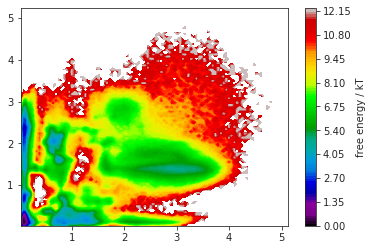

In [8]:
feats_rmsd_n_concat = np.concatenate(feats_rmsd_n) #, axis=0)
feats_rmsd_c_concat = np.concatenate(feats_rmsd_c) #, axis=0)
#feats_rmsd_n_concat = np.minimum(3.0, feats_rmsd_n_concat)
#feats_rmsd_c_concat = np.minimum(3.0, feats_rmsd_c_concat)

pyemma.plots.plot_free_energy(feats_rmsd_n_concat, feats_rmsd_c_concat)

#plt.scatter(np.concatenate(feats_rmsd_n[15:20]), np.concatenate(feats_rmsd_c[15:20]), c='red')
#plt.scatter(feats_rmsd_n[17], feats_rmsd_c[17], c='red')
#plt.scatter(feats_rmsd_n[141], feats_rmsd_c[141], c='blue')
#plt.xlim([0,5])
#plt.ylim([0,5])

In [9]:
pep_mhc_indices = []
beg = 0
end = 180
for i in range(9):
    pep_mhc_indices += range(beg, end)
    beg += 188
    end += 188

pep_pep_indices = []
beg = 180
end = 188
for i in range(9):
    pep_pep_indices += range(beg, end)
    beg += 188
    end += 188

feats = []
for i in global_traj_indices:
    i_str = str(i).zfill(4)
    if os.path.exists(i_str + "/pmhc_dist.npz"):
        pmhc_dist_file = np.load(i_str + "/pmhc_dist.npz", allow_pickle=True)
        feat = pmhc_dist_file["feats"]
        feats.append(feat)
        continue
    
    print(i)
    
    x = np.load(i_str + "/pep_to_MHC/Y.npy")

    #feat = np.min(x[:, pep_mhc_indices], axis=1)
    #feats.append(feat)

    feat = np.min(x[:, pep_mhc_indices], axis=1)
    feat_max = np.minimum(feat, 1.0) # cap the p-MHC distance
    feats.append(feat_max)
    np.savez_compressed(i_str + "/pmhc_dist.npz", feats=feat_max)
    
feats = np.array(feats)
print(feats.shape)

(160,)


In [10]:
num_n_bound = 0
num_c_bound = 0
for i in range(len(feats_rmsd_n)):
    if not os.path.exists(str(global_traj_indices[i]).zfill(4) + "/us_info.npz"): continue
    #print(i, global_traj_indices[i])
    if np.sum(feats[i] > 0.5) == 0: continue
    if np.sum(np.logical_and(feats_rmsd_n[i] < 0.2, feats_rmsd_c[i] > 1.0)) > 0: num_n_bound += 1
    elif np.sum(np.logical_and(feats_rmsd_n[i] > 1.0, feats_rmsd_c[i] < 0.2)) > 0: num_c_bound += 1
print(num_n_bound, num_c_bound)

10 3


In [11]:
if not os.path.exists('p4_phipsi.npz'):
    phis = []
    psis = []
    for i in range(len(feats_rmsd_n)):
        if not os.path.exists(str(global_traj_indices[i]).zfill(4) + "/us_info.npz"): continue
        #print(i, global_traj_indices[i])
        #if np.sum(feats[i] > 0.5) == 0: continue
        #if np.sum(np.logical_and(feats_rmsd_n[i] < 0.2, feats_rmsd_c[i] > 1.0)) > 0: num_n_bound += 1
        #elif np.sum(np.logical_and(feats_rmsd_n[i] > 1.0, feats_rmsd_c[i] < 0.2)) > 0: num_c_bound += 1
        if np.sum(np.logical_and(feats_rmsd_n[i] < 0.2, feats_rmsd_c[i] > 0.2)) > 0:
            top = glob.glob(str(global_traj_indices[i]).zfill(4) + "/aln*.pdb")[0]
            traj = md.load(str(global_traj_indices[i]).zfill(4) + "/output_every1ns_fix.dcd", top=top)
            traj = traj[np.logical_and(feats_rmsd_n[i] < 0.2, feats_rmsd_c[i] > 0.2)]
            traj = traj[::10]
            print(i, global_traj_indices[i], len(traj))
            atom_names = np.array([str(a) for a in traj.top.atoms])
            ind, ang = md.compute_phi(traj)
            phis = np.concatenate((phis,ang[:, -5]))
            ind, ang = md.compute_psi(traj)
            psis = np.concatenate((psis,ang[:, -5]))
    print(phis.shape, psis.shape)
    np.savez_compressed('p4_phipsi.npz', phis=phis, psis=psis)
else:
    f = np.load('p4_phipsi.npz')
    phis = f['phis']
    psis = f['psis']

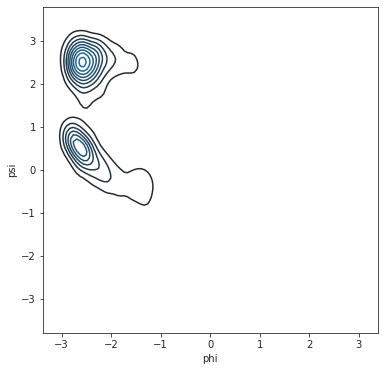

In [12]:
df_di = pd.DataFrame({'phi':phis[::10], 'psi':psis[::10]})
#plt.hist2d(phis, psis, bins=100)
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(df_di.phi, df_di.psi, ax=ax)
#ax.hist2d(phis, psis, bins=100)
plt.savefig('/home/jabella/Downloads/' + mode + '/p4_phipsi.png', dpi=500)

In [13]:
#crystal_location = "0000/aln-crystal-000000.pdb"
crystal_location = glob.glob("0000/aln-*.pdb")[0] #"0000/aln-crystal-000000.pdb"
crystal_pep_heavy_atoms = md.load(crystal_location).top.select("chainid == 1 and type != H")
crystal_peptide = md.load(crystal_location, atom_indices=crystal_pep_heavy_atoms)
print(crystal_peptide)

feats_rmsd = []
for i in global_traj_indices:
    i_str = str(i).zfill(4)
    if os.path.exists(i_str + "/pmhc_rmsd.npz"):
        pmhc_rmsd_file = np.load(i_str + "/pmhc_rmsd.npz", allow_pickle=True)
        feat_rmsd = pmhc_rmsd_file["feats_rmsd"]
        feats_rmsd.append(feat_rmsd)
        continue
        
    print(i)
    
    topfile = glob.glob(i_str + "/aln*.pdb")[0]
    pep_heavy_atoms = md.load(i_str + "/output_every1ns_fix.dcd", top=topfile).top.select("chainid == 1 and type != H")
    peptide_i = md.load(i_str + "/output_every1ns_fix.dcd", top=topfile, atom_indices=pep_heavy_atoms)
    feat = md.rmsd(peptide_i, crystal_peptide)
    feats_rmsd.append(feat)

    np.savez_compressed(i_str + "/pmhc_rmsd.npz", feats_rmsd=feat)
    
feats_rmsd = np.array(feats_rmsd)
print(feats_rmsd.shape)

<mdtraj.Trajectory with 1 frames, 77 atoms, 9 residues, without unitcells>
(160,)


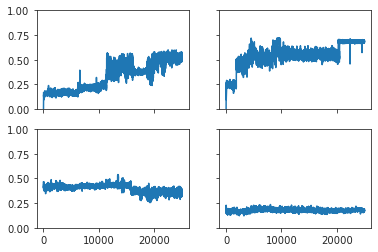

In [14]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 0].plot(feats_rmsd[10])
axs[0, 1].plot(feats_rmsd[15])
axs[1, 0].plot(feats_rmsd[-2])
axs[1, 1].plot(feats_rmsd[-10])
plt.ylim([0,1.0])
plt.savefig('/home/jabella/Downloads/' + mode + '/example_rmsds.png')

160 160
(3907102,) (3907102,)


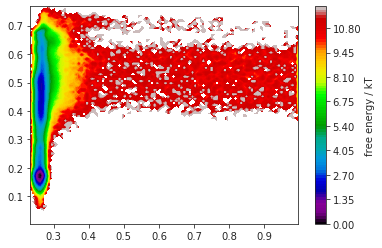

In [15]:
print(len(feats), len(feats_rmsd))
feats_concat = np.concatenate(feats) #, axis=0)
feats_rmsd_concat = np.concatenate(feats_rmsd) #, axis=0)
pyemma.plots.plot_free_energy(feats_concat, feats_rmsd_concat)

#plt.xlim([0,0.5])
print(feats_concat.shape, feats_rmsd_concat.shape)

In [16]:
if False: # save random sample of confs in macrostates
    confs0 = []
    confs1 = []
    confs2 = []
    confs3 = []
    confs4 = []
    for i in range(len(feats)):
        for j in range(len(feats[i])):
            if feats[i][j] > 0.5: confs4.append((i,j))
            elif feats_rmsd[i][j] < 0.2: confs0.append((i,j))
            elif feats_rmsd_n[i][j] < 0.2 and feats_rmsd_c[i][j] > 0.2: confs1.append((i,j))
            elif feats_rmsd_n[i][j] > 0.2 and feats_rmsd_c[i][j] < 0.2: confs2.append((i,j))
            else: confs3.append((i,j))
    print(len(confs0), len(confs1), len(confs2), len(confs3), len(confs4))
    all_confs = [confs0, confs1, confs2, confs3, confs4]
    for j,confs in enumerate(all_confs):
        print(j)
        random_subset = np.random.choice(len(confs), size=100, replace=False)
        confs = np.array(confs)
        all_obj = []
        for t,f in confs[random_subset]:
            topfile = glob.glob(str(global_traj_indices[t]).zfill(4) + "/*.pdb")[0]
            trajfile = str(global_traj_indices[t]).zfill(4) + "/output_every1ns_fix.dcd"
            all_obj.append(md.load_frame(trajfile, f, top=topfile))
        full_traj = all_obj[0]
        for i in range(1,100): 
            try: full_traj += all_obj[i]
            except: continue
        full_traj.save_dcd("/home/jabella/Downloads/" + mode + "/confs" + str(j) + ".dcd")

In [17]:
if False: # concatenate us trajectories that fully detach
    num_us_trajs = 0
    num_detached = 0
    trajs = []
    for i in range(len(feats_rmsd_c)):
        i_str = str(global_traj_indices[i]).zfill(4)
        if not os.path.exists(i_str + "/us_info.npz"): continue
        num_us_trajs += 1
        is_detached = list(np.logical_and(feats_rmsd_n[i] > 1.0, feats_rmsd_c[i] > 1.0))
        #is_detached = list(feats[i] > 0.5)
        if np.sum(is_detached) > 0: 
            num_detached += 1
            topfile = glob.glob(i_str + "/aln-*.pdb")[0]
            traj = md.load(i_str + "/output_every1ns_fix.dcd",top=topfile)
            when_detached = is_detached.index(True)
            traj = traj[:when_detached+30]
            if when_detached < 250: continue
            traj_smooth = traj.smooth(width=250)
            trajs.append(traj_smooth[::50])
            print(i, global_traj_indices[i], when_detached)
    num_reg_trajs = len(global_traj_indices) - num_us_trajs
    print(num_detached, num_us_trajs, num_reg_trajs)
    full_traj_concat = trajs[0]
    for i in range(1, len(trajs)): full_traj_concat += trajs[i]
    full_traj_concat.save_dcd("traj_concat.dcd")

## TICA

In [15]:
traj_filenames = [str(i).zfill(4) for i in global_traj_indices]
inp = []
for i,traj_folder in enumerate(traj_filenames):
    if (i%10) == 0: print(i)
    input_prefix = traj_folder + "/pep_to_MHC"
    inp_i = input_prefix + "/Y.npy"
    Y = np.load(inp_i)
    inp.append(Y)
    #inp.append(np.minimum(1.0, Y))
    
    #feat = feats_rmsd_n[i]
    #feat2 = feats_rmsd_c[i]
    #inp.append( np.concatenate((Y, feat.reshape(-1,1), feat2.reshape(-1,1) ), axis=1) )
    
    #feat = feats[i]
    #feat2 = feats_rmsd[i]
    #inp.append( np.concatenate((Y, feat.reshape(-1,1) ), axis=1) )

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210


In [16]:
# skip this because we are adding a new feature in the previous cell
"""
traj_filenames = [str(i).zfill(4) for i in global_traj_indices]
inp_str = []
for traj_folder in traj_filenames:
    input_prefix = traj_folder + "/pep_to_MHC"
    inp_i = input_prefix + "/Y.npy"
    inp_str.append(inp_i)

inp = pyemma.coordinates.load(inp_str)
"""

'\ntraj_filenames = [str(i).zfill(4) for i in global_traj_indices]\ninp_str = []\nfor traj_folder in traj_filenames:\n    input_prefix = traj_folder + "/pep_to_MHC"\n    inp_i = input_prefix + "/Y.npy"\n    inp_str.append(inp_i)\n\ninp = pyemma.coordinates.load(inp_str)\n'

In [17]:
print("Num trajs:", len(inp))
print("Num features:", inp[0].shape[1])
num_frames = np.sum([inp_i.shape[0] for inp_i in inp])
print("Num frames:", num_frames)
print("Total sim time:", num_frames*steps_to_nanoseconds, " ns")

Num trajs: 213
Num features: 1692
Num frames: 4845213
Total sim time: 193808.52  ns


In [18]:
bound_inp = [inp_i for i,inp_i in enumerate(inp) if i in local_bound_trajs]
unbound_inp = [inp_i for i,inp_i in enumerate(inp) if i in local_unbound_trajs]

In [16]:
TICA_lagtimes = 25*np.array([1,10,25,50,75,100,250,500])
if os.path.exists("tica_timescales.npz"):
    f = np.load("tica_timescales.npz")
    lags = f["lags"]
    all_tica_timescales = f["timescales"]
else:
    all_tica_timescales = []
    for l in TICA_lagtimes:
        print("lag:",l)
        tica_obj_temp = pyemma.coordinates.tica(inp, lag=l, commute_map=True, kinetic_map=False, dim=50)
        tica_timescales = tica_obj_temp.timescales
        all_tica_timescales.append(tica_timescales)
    np.savez_compressed("tica_timescales.npz", lags=TICA_lagtimes, timescales=all_tica_timescales)

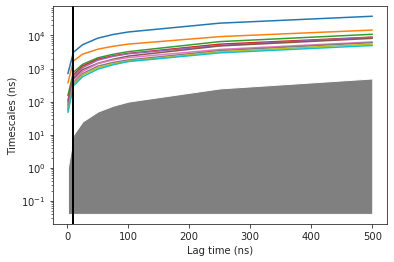

In [17]:
lags = TICA_lagtimes
nlags = lags.shape[0]
ts_list = np.zeros((nlags, 10))
for i, lag in enumerate(lags):
    timescales = all_tica_timescales[i]
    ts_list[i, :] = timescales[:10]

ts_list *= steps_to_nanoseconds

plt.semilogy(lags * steps_to_nanoseconds, ts_list)
plt.ylabel('Timescales (ns)')
plt.xlabel('Lag time (ns)')
plt.fill_between(lags * steps_to_nanoseconds, 1*steps_to_nanoseconds, lags * steps_to_nanoseconds, facecolor='Gray')

plt.axvline(10, linewidth=2, color='black')
plt.savefig('/home/jabella/Downloads/' + mode + '/tica_ts_over_lags.png', dpi=500)

In [59]:
if not os.path.exists("tica_coor.npz"):
    if mode == "wild":
        tica_obj = pyemma.coordinates.tica(inp, lag=10*25, commute_map=True, kinetic_map=False, dim=50) #, weights="koopman")
        tica_y = tica_obj.get_output(dimensions=np.arange(30))
        tica_obj.save("tica","wild")
    elif mode == "D4A":
        #tica_obj = pyemma.load("../native_state_us/tica","wild")
        #tica_y = tica_obj.transform(inp)
        tica_obj = pyemma.coordinates.tica(inp, lag=10*25, commute_map=True, kinetic_map=False, dim=50) #, weights="koopman")
        tica_y = tica_obj.get_output(dimensions=np.arange(30))
        tica_obj.save("tica","D4A",overwrite=True)
    print("Saving")
    np.savez_compressed("tica_coor.npz",tica_y=tica_y)
else:
    print("Loading")
    #tica_obj = pyemma.load("../native_state_us/tica","wild")
    tica_obj = pyemma.load("tica",mode)
    tica_y = np.load("tica_coor.npz", allow_pickle=True)["tica_y"]

Loading


In [60]:
feat_des = np.load("pep_to_MHC/feats_des.npz")['feat']
#feat_des = np.concatenate( (feat_des, ["pMHC_dist"]) )
print(feat_des.shape)
num_feats = 5
tica_corr = tica_obj.feature_TIC_correlation
for i in range(5):
    TIC_i = abs(tica_corr)[:, i]
    sorted_ind_i = np.argsort(TIC_i)
    print(feat_des[sorted_ind_i][-num_feats:])
    print(TIC_i[sorted_ind_i][-num_feats:])

(1692,)
['RES_DIST (closest-heavy) LYS3 - ASP122'
 'RES_DIST (closest-heavy) LYS3 - GLY120'
 'RES_DIST (closest-heavy) LYS3 - ASP119'
 'RES_DIST (closest-heavy) LYS3 - LYS121'
 'RES_DIST (closest-heavy) LYS3 - TYR118']
[117.09292411 117.25404253 117.77953375 118.25180267 118.44755751]
['RES_DIST (closest-heavy) ILE7 - HIS114'
 'RES_DIST (closest-heavy) ILE7 - LYS121'
 'RES_DIST (closest-heavy) ILE7 - GLN96'
 'RES_DIST (closest-heavy) ILE7 - GLN115'
 'RES_DIST (closest-heavy) ILE7 - ALA117']
[95.25581683 95.27933313 95.70929925 95.88454732 96.0340627 ]
['RES_DIST (closest-heavy) ASN5 - GLU62'
 'RES_DIST (closest-heavy) VAL6 - ASP166'
 'RES_DIST (closest-heavy) VAL6 - GLU173'
 'RES_DIST (closest-heavy) VAL6 - GLU177'
 'RES_DIST (closest-heavy) ALA4 - HIS70']
[45.1795783  45.21201284 45.23174174 45.70888095 47.71889917]
['RES_DIST (closest-heavy) LEU9 - ARG108'
 'RES_DIST (closest-heavy) LEU9 - LEU110'
 'RES_DIST (closest-heavy) VAL6 - ALA150'
 'RES_DIST (closest-heavy) ASN5 - GLN72'
 'RE

(4845213, 30)


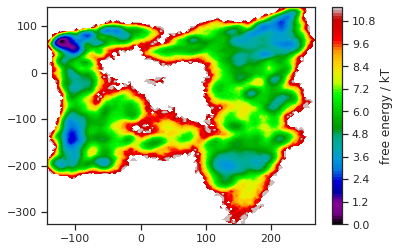

In [61]:
Y_concat = np.concatenate(tica_y, axis=0)
print(Y_concat.shape)
pyemma.plots.plot_free_energy(Y_concat[:,0], Y_concat[:,1])
plt.savefig('/home/jabella/Downloads/' + mode + '/tica_notweighted.png', dpi=500)

-104.17128 36.466583
129.58458 -179.6952
118.81871 -197.67926
152.58864 -168.37166
123.52661 -81.55921
21.369518 4.6713557
129.58458 -179.6952
118.81871 -197.67926
152.58864 -168.37166
123.52661 -81.55921
21.369518 4.6713557


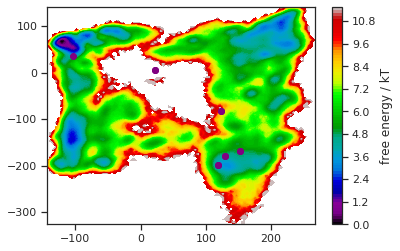

In [62]:
dim0 = 0
dim1 = 1
pyemma.plots.plot_free_energy(Y_concat[:,dim0], Y_concat[:,dim1])

#for i in umbrella_sampling_l_indices:
#    plt.scatter(tica_y[i][0, 1], tica_y[i][0, 4], c='black')
#plt.scatter(tica_y[-11][:, dim0], tica_y[-11][:, dim1], c='red')
#plt.scatter(tica_y[-4][:, dim0], tica_y[-4][:, dim1], c='blue')
#plt.scatter(tica_y[-5][:, dim0], tica_y[-5][:, dim1], c='purple')
for i in range(11):
    print(tica_y[-i][0, dim0], tica_y[-i][0, dim1])
    plt.scatter(tica_y[-i][0, dim0], tica_y[-i][0, dim1], c='purple')

Text(12.5, 0.5, 'Timescale (ns)')

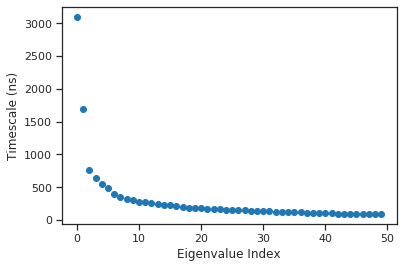

In [63]:
tica_timescales = tica_obj.timescales * steps_to_nanoseconds
plt.scatter(np.arange(len(tica_timescales))[:50], tica_timescales[:50])
#plt.ylim([0,1000])
plt.savefig('/home/jabella/Downloads/' + mode + '/tica_ts.png')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Timescale (ns)")

## Discretization

In [18]:
if os.path.exists("discretization2.npz"):
    if mode == "wild": f = np.load("discretization2.npz", allow_pickle=True) #wild
    elif mode == "D4A": f = np.load("discretization2.npz", allow_pickle=True) #D4A
    dtrajs = list(f['dtrajs'])
    cc_all = f['cc_all']
    index_clusters = f['index_clusters']
    n_clusters = len(index_clusters)
    f.close()
else:
    new_trajs = []
    for j in range(len(inp)):
        feat_j = feats[j].reshape(len(feats[j]),1)
        feat_rmsd_j = feats_rmsd[j].reshape(len(feats_rmsd[j]),1)
        feat_rmsd_n_j = feats_rmsd_n[j].reshape(len(feats_rmsd_n[j]),1)
        feat_rmsd_c_j = feats_rmsd_c[j].reshape(len(feats_rmsd_c[j]),1)

        #new_trajs.append(np.concatenate( (feat_rmsd_n_j, feat_rmsd_c_j), axis=1))
        new_trajs.append(tica_y[j][:, :2])
        
    clustering = pyemma.coordinates.cluster_kmeans(new_trajs, k=100, max_iter=20, stride=25)

    n_clusters = clustering.n_clusters
    cc_all = clustering.clustercenters
    index_clusters = clustering.index_clusters
    index_clusters_shapes = [ici.shape[0] for ici in index_clusters]

    dtrajs = clustering.dtrajs
    print(n_clusters)
    
    np.savez_compressed("discretization2.npz", dtrajs=dtrajs, cc_all=cc_all, index_clusters=index_clusters)
    

0.3747578561306


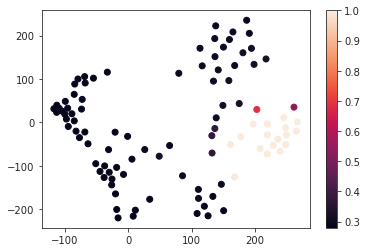

In [19]:
# plot pMHC distance
cluster_feats = []
for j in range(len(index_clusters)):
    cluster = index_clusters[j]
    conf_feats = []
    for i in range(len(cluster)):
        trajindex, frameindex = cluster[i]
        conf_feats.append(feats[trajindex][frameindex])
    aggregated_feats = np.max(conf_feats)
    cluster_feats.append(aggregated_feats)

cluster_feats = [min(1.0, c) for c in cluster_feats]
cluster_feats = np.array(cluster_feats)
print(cluster_feats[-1])
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats)
plt.colorbar()

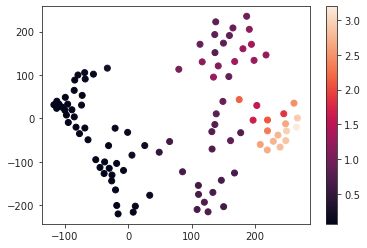

In [20]:
# plot rmsd of n-term anchor
cluster_feats_rmsd = []
for j in range(len(index_clusters)):
    cluster = index_clusters[j]
    conf_feats_1 = []
    conf_feats_2 = []
    for i in range(len(cluster)):
        trajindex, frameindex = cluster[i]
        conf_feats_1.append(feats_rmsd_n[trajindex][frameindex])
        conf_feats_2.append(feats_rmsd_c[trajindex][frameindex])
    aggregated_feats_1 = np.median(conf_feats_1)
    aggregated_feats_2 = np.median(conf_feats_2)
    cluster_feats_rmsd.append((aggregated_feats_1, aggregated_feats_2))

cluster_feats_rmsd = np.array(cluster_feats_rmsd)
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats_rmsd[:,0])
plt.colorbar()

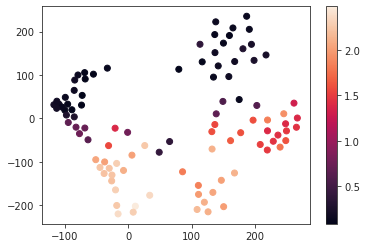

In [21]:
# plot rmsd of c-term anchor
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats_rmsd[:,1])
plt.colorbar()

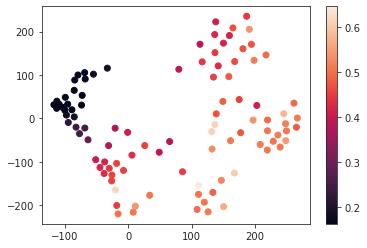

In [22]:
# rmsd from native state
cluster_feats_r = []
for j in range(len(index_clusters)):
    cluster = index_clusters[j]
    conf_feats = []
    for i in range(len(cluster)):
        trajindex, frameindex = cluster[i]
        conf_feats.append(feats_rmsd[trajindex][frameindex])
    aggregated_feats = np.median(conf_feats)
    cluster_feats_r.append(aggregated_feats)

#cluster_feats = [min(1.0, c) for c in cluster_feats]
cluster_feats_r = np.array(cluster_feats_r)
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=cluster_feats_r)
#plt.xlim([0,0.5])
#plt.ylim([0,0.5])
plt.colorbar()

In [23]:
# stats of count matrix
c_matrix = msmtools.estimation.cmatrix(dtrajs, 250, sparse_return=False)
largest_connected_set = msmtools.estimation.largest_connected_set(c_matrix)

unbound_states = []
associated_states = []
for i,c in enumerate(cluster_feats):
    if c >= 0.5: 
        unbound_states.append(i) #np.argwhere(MSM.active_set == i)[0][0])
    else: associated_states.append(i)
        
#for s in unbound_states: 
#    if s in largest_connected_set: print(s)
        
a_to_u = np.sum(c_matrix[associated_states, :][:, unbound_states])
u_to_a = np.sum(c_matrix[unbound_states, :][:, associated_states])
u_to_u = np.sum(c_matrix[unbound_states, :][:, unbound_states])
a_to_a = np.sum(c_matrix[associated_states, :][:, associated_states])
print(a_to_u, u_to_a, u_to_u, a_to_a)
print(a_to_u+u_to_a+u_to_u+a_to_a)
print(np.sum(c_matrix.sum()))
        
print(c_matrix.shape, largest_connected_set.shape)

10735.0 5291.0 445227.0 3405849.0
3867102.0
3867102.0
(100, 100) (100,)


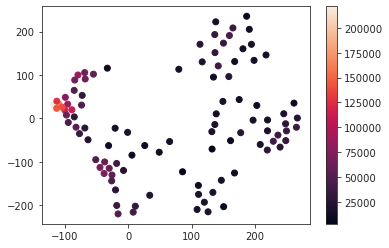

In [24]:
# number of transitions originating from state
plt.scatter(cc_all[:, 0], cc_all[:, 1], c=np.sum(c_matrix, axis=1)) #c=np.minimum(400, np.sum(c_matrix, axis=1)))
plt.colorbar()

In [25]:
# state definitions
unbound_states = []
associated_states = []
native_states = []
cterm_bound_states = []
nterm_bound_states = []
anchor_cutoff = 0.2
for i in range(len(cluster_feats)):
    nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[i]
    #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(i)
    if cluster_feats_r[i] < 0.2: native_states.append(i)
    elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: cterm_bound_states.append(i)
    elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: nterm_bound_states.append(i)
    #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
    elif cluster_feats[i] > 0.5: unbound_states.append(i)
    else: associated_states.append(i)
print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)

not_native = associated_states + unbound_states + cterm_bound_states + nterm_bound_states
n_to_nn = np.sum(c_matrix[native_states, :][:, not_native])
nn_to_n = np.sum(c_matrix[not_native, :][:, native_states])

print(len(native_states))
print(n_to_nn, nn_to_n)
print(np.sum(c_matrix[native_states, :][:, cterm_bound_states]), np.sum(c_matrix[native_states, :][:, nterm_bound_states]))

[1, 10, 17, 24, 26, 30, 34, 36, 44, 60, 69, 73, 76, 78, 83, 86, 89, 97, 98] [0, 6, 20, 23, 29, 39, 41, 42, 43, 49, 50, 59, 72, 77, 79, 82, 88, 90, 92, 94] [8, 12, 18, 21, 28, 32, 38, 52, 54, 62, 63, 65, 67, 85, 96] [2, 4, 9, 11, 15, 16, 19, 22, 25, 27, 35, 37, 40, 51, 55, 56, 57, 61, 64, 66, 68, 70, 75, 81, 91]
20
22878.0 16624.0
676.0 20908.0


## DTRAM/MSM

In [26]:
kT = 2.479
umbrella_sampling_g_indices = []
umbrella_sampling_l_indices = []
us_trajs = []
md_trajs = []
us_centers = []
us_force_constants = []
unbiased_g_trajs = []
unbiased_l_trajs = []

for progress, i in enumerate(global_traj_indices):
    if os.path.exists(str(i).zfill(4) + "/dCOM.npz"):
        dCOM = np.load(str(i).zfill(4) + "/dCOM.npz", allow_pickle=True)["dCOM"]
    else:
        print(progress)
        file_prefix = str(i).zfill(4) + "/"
        topfile = glob.glob(file_prefix + "aln*.pdb")[0]
        f = md.load(file_prefix + "output_every1ns_fix.dcd", top=topfile)
        peptide = f.top.select("chainid == 1")
        mhc = f.top.select("chainid != 1 and name == 'CA' and (resi < 45 or (resi >= 95 and resi <= 120))")

        peptide_frame = f.atom_slice(atom_indices=peptide, inplace=False)
        mhc_frame = f.atom_slice(atom_indices=mhc, inplace=False)

        pep_com = md.compute_center_of_mass(peptide_frame)
        mhc_com = md.compute_center_of_mass(mhc_frame)

        dCOM = np.abs(pep_com - mhc_com)[:,2]
        np.savez_compressed(str(i).zfill(4) + "/dCOM.npz", dCOM=dCOM)
        
    if os.path.exists(str(i).zfill(4) + "/us_info.npz"):
        us_info_file = np.load(str(i).zfill(4) + "/us_info.npz", allow_pickle=True)
        us_centers.append(us_info_file["center"])
        us_force_constants.append(us_info_file["force_constant"] / kT)
        us_trajs.append(dCOM)
        umbrella_sampling_g_indices.append(i)
        umbrella_sampling_l_indices.append(progress)
        
    else:
        md_trajs.append(dCOM)
        unbiased_g_trajs.append(i)
        unbiased_l_trajs.append(progress)
        
        
#us_centers = np.array(us_centers)
#us_force_constants = np.array(us_force_constants)
print(len(us_trajs), len(md_trajs))
print(us_centers)
print(us_force_constants)

us_dtrajs = [dtrajs[i] for i in umbrella_sampling_l_indices]
md_dtrajs = [dtrajs[i] for i in unbiased_l_trajs]

62 98
[array(1.), array(1.1), array(1.2), array(1.3), array(1.4), array(1.5), array(1.6), array(1.7), array(1.8), array(1.9), array(2.), array(2.1), array(2.2), array(2.3), array(2.4), array(2.5), array(2.6), array(2.7), array(2.8), array(2.9), array(3.), array(1.), array(1.1), array(1.2), array(1.3), array(1.4), array(1.5), array(1.6), array(1.7), array(1.8), array(1.9), array(2.), array(2.1), array(2.2), array(2.3), array(2.4), array(2.5), array(2.6), array(2.7), array(2.8), array(2.9), array(2.), array(2.1), array(2.2), array(2.4), array(2.5), array(2.6), array(2.7), array(2.8), array(2.9), array(3.), array(2.), array(2.1), array(2.2), array(2.3), array(2.4), array(2.5), array(2.6), array(2.7), array(2.8), array(2.9), array(3.)]
[40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.338846308995564, 40.33884630899556

62 98
100


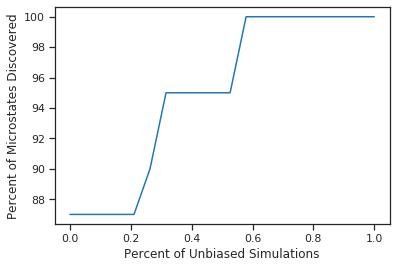

In [27]:
sns.set_context("notebook")
print(len(us_dtrajs), len(md_dtrajs))
all_trajs_concat = np.concatenate((us_dtrajs + md_dtrajs), axis=0)
print(len(set(all_trajs_concat)))
num_discovered_states = []
unbiased_percentages = np.linspace(0,1,20) #[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for p in unbiased_percentages:
    num_unbiased = int(np.floor(len(md_dtrajs) * p))
    #print(num_unbiased)
    all_trajs_concat = np.concatenate((us_dtrajs + md_dtrajs[:num_unbiased]), axis=0)
    num_discovered_states.append(len(set(all_trajs_concat)))
plt.plot(unbiased_percentages, num_discovered_states)
plt.xlabel("Percent of Unbiased Simulations")
plt.ylabel("Percent of Microstates Discovered")
plt.savefig('/home/jabella/Downloads/' + mode + '/microstates_over_unbiased.png')

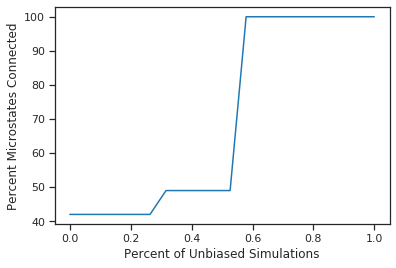

In [28]:
num_largest_set = []
unbiased_percentages = np.linspace(0,1,20) #[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for p in unbiased_percentages:
    num_unbiased = int(np.floor(len(md_dtrajs) * p))
    c_matrix = msmtools.estimation.cmatrix(us_dtrajs + md_dtrajs[:num_unbiased], 250*25, sparse_return=False)
    largest_connected_set = msmtools.estimation.largest_connected_set(c_matrix)
    num_largest_set.append(len(largest_connected_set))
plt.plot(unbiased_percentages, num_largest_set)
plt.xlabel("Percent of Unbiased Simulations")
plt.ylabel("Percent Microstates Connected")
plt.savefig('/home/jabella/Downloads/' + mode + '/connection_over_unbiased.png')

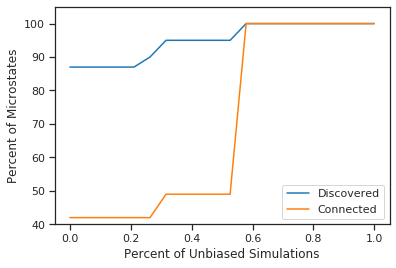

In [29]:
sns.set_context("notebook")
sns.set_style("ticks")
plt.plot(unbiased_percentages, num_discovered_states)
plt.plot(unbiased_percentages, num_largest_set)
plt.legend(["Discovered","Connected"])
plt.ylim([40,105])
plt.xlabel("Percent of Unbiased Simulations")
plt.ylabel("Percent of Microstates")
plt.savefig('/home/jabella/Downloads/' + mode + '/both_over_unbiased.png', dpi=500)

In [34]:
all_msm_lags = 25*np.array([1,10,25,50,75,100,250,500])
#all_msm_lags = 25*np.array([1,10,25,50,75,100,200,300,500])
if os.path.exists("msm_timescales.npz"):
    f = np.load("msm_timescales.npz", allow_pickle=True)
    lags = f["lags"]
    all_msm_timescales = f["timescales"]
else:
    all_msm_timescales = []
    for l in all_msm_lags:
        print("lag:",l)
        us_temp = pyemma.thermo.estimate_umbrella_sampling(us_trajs=us_trajs, us_dtrajs=us_dtrajs, 
                                                  us_centers=us_centers, us_force_constants=us_force_constants,
                                                  md_trajs=md_trajs, md_dtrajs=md_dtrajs, estimator="dtram", lag=l, 
                                                  width=None, save_convergence_info=1, maxiter=10000)#, maxerr=1E-6)

        MSM = us_temp.msm
        timescales = MSM.timescales()
        all_msm_timescales.append(timescales)
    np.savez_compressed("msm_timescales.npz", lags=all_msm_lags, timescales=all_msm_timescales)
    

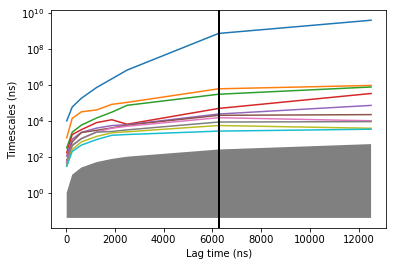

In [35]:
lags = all_msm_lags
nlags = lags.shape[0]
ts_list = np.zeros((nlags, 10))
for i, lag in enumerate(lags):
    timescales = all_msm_timescales[i]
    ts_list[i, :] = timescales[:10]

ts_list *= steps_to_nanoseconds

plt.semilogy(lags, ts_list)
plt.ylabel('Timescales (ns)')
plt.xlabel('Lag time (ns)')
plt.fill_between(lags, 1*steps_to_nanoseconds, lags * steps_to_nanoseconds, facecolor='Gray')

plt.axvline(250*25, linewidth=2, color='black')

In [30]:
if os.path.exists("us_obj"):
    us = pyemma.load("us_obj","us_obj")
    MSM = pyemma.load("msm_obj","msm_obj")

    active_set = us.active_set
    mu = us.stationary_distribution
    nstates = us.nstates
else:
    if mode == "wild": us_lag = 250*25
    elif mode == "D4A": us_lag = 250*25
    us = pyemma.thermo.estimate_umbrella_sampling(us_trajs=us_trajs, us_dtrajs=us_dtrajs, 
                                                  us_centers=us_centers, us_force_constants=us_force_constants,
                                                  md_trajs=md_trajs, md_dtrajs=md_dtrajs, estimator="dtram", lag=us_lag, 
                                                  width=None, save_convergence_info=1, maxiter=10000)#, maxerr=1E-6)
    
    MSM = us.msm

    active_set = us.active_set
    mu = us.stationary_distribution
    nstates = us.nstates
    
    us.save("us_obj","us_obj",overwrite=True)
    MSM.save("msm_obj","msm_obj",overwrite=True)

/home/jabella/miniconda2/envs/py3/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:46: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(name) as h5f:
/home/jabella/miniconda2/envs/py3/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


(0, 0.001)

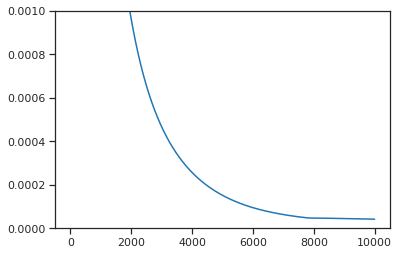

In [31]:
plt.plot(us.increments)
plt.ylim([0, 1E-3])
#print([f.shape for f in us.pointwise_free_energies()])
#dir(us)

[]


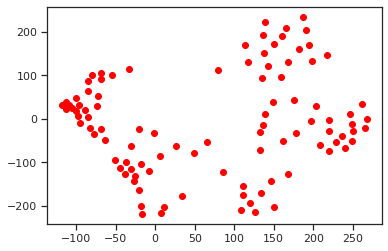

In [32]:
not_in_active_set = [i for i in range(len(cc_all)) if i not in active_set]
print(not_in_active_set)
dim0 = 0
dim1 = 1
plt.scatter(cc_all[active_set, dim0], cc_all[active_set, dim1], c="r")
plt.scatter(cc_all[not_in_active_set, dim0], cc_all[not_in_active_set, dim1], c="b")

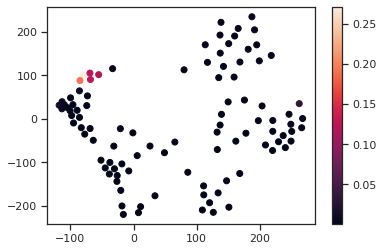

In [33]:
#print(us.active_set)
#print(us.stationary_distribution.shape, np.sum(us.stationary_distribution))
plt.scatter(cc_all[active_set, 0], cc_all[active_set, 1], c=mu)
plt.colorbar()

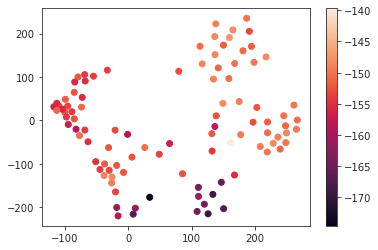

In [29]:
if mode == "wild":
    mutant = "D4"

    RT = 2.479
    beta = 1. / RT
    num_confs_per_cluster = [len(ic) for ic in index_clusters]
    dEnergy = []
    rw_factors = [[] for _ in range(nstates)]
    for i, traj in enumerate(dtrajs):
        global_traj_index = global_traj_indices[i]

        wild_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/wild.txt", 'r')
        for line in f:
            line_arr = line.split()
            wild_energies.append(float(line_arr[0]))
            #if float(line_arr[0]) > 0: print float(line_arr[0])
        f.close()

        mut_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/" + mutant + ".txt", 'r')
        for line in f:
            line_arr = line.split()
            mut_energies.append(float(line_arr[0]))
        f.close()
        cluster_assignments_in_traj = traj[::25]
        #if len(traj)-len(mut_energies) == 1: cluster_assignments_in_traj = cluster_assignments_in_traj[:-1]

        wild_energies = np.array(wild_energies)
        mut_energies = np.array(mut_energies)

        for j,cluster_index in enumerate(cluster_assignments_in_traj):
            if cluster_index not in active_set: continue

            MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
            reweighting_factor = np.exp( beta * (wild_energies[j] - mut_energies[j]) )

            rw_factors[MSM_cluster_index].append(reweighting_factor)

    avg_rw_factors = [np.log(np.mean(rw_factors[ci])) for ci in range(nstates)]
    plt.scatter(cc_all[active_set, 0], cc_all[active_set, 1], c=avg_rw_factors)
    plt.colorbar()

[2.45357360e+07 1.24747203e+06 8.08471455e+05 1.34527574e+05
 9.62104601e+04 5.06733759e+04 1.90444009e+04 8.20555664e+03
 7.22470256e+03 5.39102298e+03]


Text(0, 0.5, 'MSM Timescale (ns)')

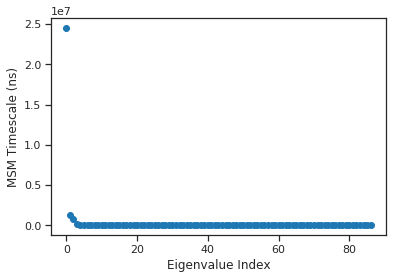

In [34]:
timescales = MSM.timescales() * steps_to_nanoseconds
print(timescales[:10])
plt.scatter(np.arange(len(timescales)), timescales)
#plt.ylim([0, 100000])
plt.xlabel("Eigenvalue Index")
plt.ylabel("MSM Timescale (ns)")

In [35]:
weights = []
dtrajs_concat = np.concatenate(dtrajs, axis=0)
mu = us.stationary_distribution
for cluster_index in dtrajs_concat:
    if cluster_index not in active_set: weights.append(0.0)
    else:
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        num_conf_in_cluster = len(index_clusters[cluster_index])
        weights.append(mu[MSM_cluster_index] / num_conf_in_cluster)

#weights = np.concatenate(us.pointwise_free_energies(), axis=0)
print(np.sum(weights))


1.0


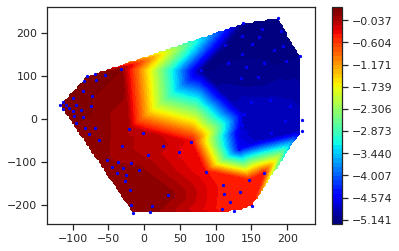

In [36]:
r2 = MSM.eigenvectors_right()[:, 1]
pyemma.plots.scatter_contour(cc_all[MSM.active_set, 0], cc_all[MSM.active_set, 1], r2)

[1, 10, 17, 24, 26, 30, 34, 36, 44, 60, 69, 73, 76, 78, 83, 86, 89, 97, 98]


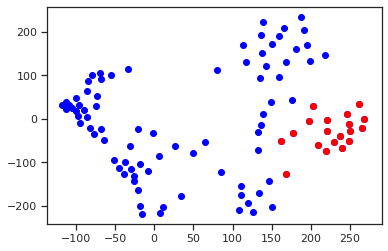

In [37]:
unbound_states = []
for i,c in enumerate(cluster_feats):
    if c >= 0.5 and i in active_set: 
    #if i in MSM.active_set and MSM.metastable_assignments[np.argwhere(MSM.active_set == i)[0][0]] == 4:
        unbound_states.append(np.argwhere(active_set == i)[0][0])
print(unbound_states)
dim0 = 0
dim1 = 1
plt.scatter(cc_all[active_set, dim0], cc_all[active_set, dim1], c="b")
plt.scatter(cc_all[active_set[unbound_states], dim0], cc_all[active_set[unbound_states], dim1], c="r")

In [38]:
# state definitions
unbound_states = []
associated_states = []
native_states = []
cterm_bound_states = []
nterm_bound_states = []
anchor_cutoff = 0.2
state_to_macrostate = []
print(nstates, len(active_set))
active_set_coords = []
for MSM_state in range(nstates):
    cluster_index = active_set[MSM_state]
    active_set_coords.append(cc_all[cluster_index])
    nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
    #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(MSM_state)
    if cluster_feats_r[cluster_index] < 0.2: 
        native_states.append(MSM_state)
        state_to_macrostate.append(0)
    elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
        cterm_bound_states.append(MSM_state)
        state_to_macrostate.append(2)
    elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
        nterm_bound_states.append(MSM_state)
        state_to_macrostate.append(1)
    #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
    elif cluster_feats[cluster_index] > 0.5: 
        unbound_states.append(MSM_state)
        state_to_macrostate.append(4)
    else: 
        associated_states.append(MSM_state)
        state_to_macrostate.append(3)
#print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)
print(len(unbound_states))
macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]
print(np.sum(macro_p))
print(macro_p)

100 100
19
0.9999999999999998
[0.9062018031626362, 0.008699018851014758, 0.0255632672659701, 0.007459256359458443, 0.05207665436092025]


In [39]:
#unbound_states = [100]
#unbound_states = [MSM.nstates-1]
#bound_states = [j for j in range(MSM.nstates) if j not in unbound_states]
bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states
#print(MSM.mfpt(unbound_states, bound_states))
#print(MSM.mfpt(bound_states, unbound_states))
RT = 2.479
dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
print("p(Bound):", np.sum(mu[bound_states]))
print("p(Unbound):", np.sum(mu[unbound_states]))
print("RT*ln(p_unbound / p_bound):", dG)

p(Bound): 0.9479233456390795
p(Unbound): 0.05207665436092025
RT*ln(p_unbound / p_bound): -7.192959516675874


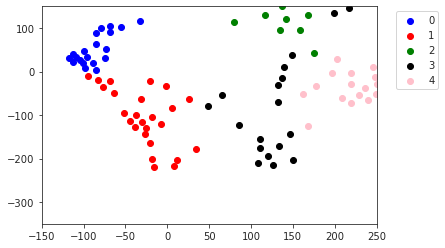

In [36]:
plt.scatter(cc_all[active_set[native_states], 0], cc_all[active_set[native_states], 1], c="b")
plt.scatter(cc_all[active_set[nterm_bound_states], 0], cc_all[active_set[nterm_bound_states], 1], c="r")
plt.scatter(cc_all[active_set[cterm_bound_states], 0], cc_all[active_set[cterm_bound_states], 1], c="g")
plt.scatter(cc_all[active_set[associated_states], 0], cc_all[active_set[associated_states], 1], c="black")
plt.scatter(cc_all[active_set[unbound_states], 0], cc_all[active_set[unbound_states], 1], c="pink")
plt.xlim([-150,250])
plt.ylim([-350,150])
plt.legend(["0", "1", "2", "3", "4"], loc="upper right", bbox_to_anchor=(1.2, 1))
plt.savefig('/home/jabella/Downloads/' + mode + '/macrostate_clusters.png', dpi=500, bbox_inches='tight')

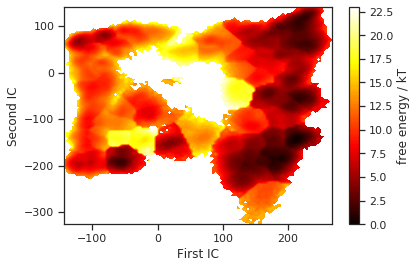

In [84]:
sns.set_context("notebook")
sns.set_style("ticks")
pyemma.plots.plot_free_energy(Y_concat[:,0], Y_concat[:,1], weights=weights, cmap=plt.cm.hot) #, cbar_orientation="horizontal", cbar=False,ax=ax)
plt.xlabel("First IC")
plt.ylabel("Second IC")
plt.savefig('/home/jabella/Downloads/' + mode + '/tica_reweighted.png', dpi=500, bbox_inches="tight")

In [85]:
tica_x_concat = []
tica_y_concat = []
macrostate_traj_concat = []
for t,dtraj in enumerate(dtrajs):
    for i,cluster_index in enumerate(dtraj):
        if cluster_index not in active_set: continue
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        tica_x_concat.append(tica_y[t][i,0])
        tica_y_concat.append(tica_y[t][i,1])
        macrostate_traj_concat.append(state_to_macrostate[MSM_cluster_index])


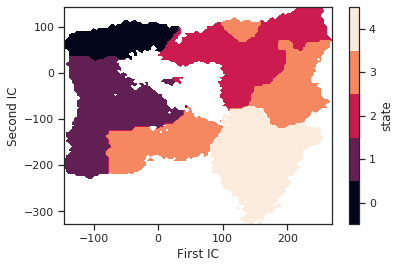

In [86]:
sns.set_style("ticks")
pyemma.plots.plot_state_map(np.array(tica_x_concat), np.array(tica_y_concat), np.array(macrostate_traj_concat), ncontours=5, cbar_label="state")
plt.xlabel("First IC")
plt.ylabel("Second IC")
plt.savefig('/home/jabella/Downloads/' + mode + '/tica_reweighted_labeled.png', dpi=500, bbox_inches="tight")

In [16]:
if not os.path.exists("contact_prob_peppep.npz"):
    print("Computing contacts")
    is_contact = []
    for i in global_traj_indices:
        if i%10 == 0: print(i)
        i_str = str(i).zfill(4)    
        x = np.load(i_str + "/pep_to_MHC/Y.npy")
        #print(x.shape, x[:,pep_mhc_indices].shape)
        is_contact.append(x[:,pep_pep_indices] < 0.35)

    print("Organizing")
    contacts_per_macrostate = [[] for i in range(5)]
    from collections import defaultdict
    contact_macro_p = defaultdict(lambda: np.zeros((5,)))
    for cluster_index in range(len(index_clusters)):
        print(cluster_index)
        if cluster_index not in active_set: continue
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        num_conf_in_cluster = len(index_clusters[cluster_index])
        conf_prob = (mu[MSM_cluster_index]/num_conf_in_cluster) / macro_p[state_to_macrostate[MSM_cluster_index]]
        for trajindex, frameindex in index_clusters[cluster_index]:
            all_contacts = feat_des[pep_pep_indices][is_contact[trajindex][frameindex]]
            #contacts_per_macrostate[state_to_macrostate[MSM_cluster_index]] = np.concatenate((contacts_per_macrostate[state_to_macrostate[MSM_cluster_index]], all_contacts), axis=0)
            #contacts_per_macrostate[state_to_macrostate[MSM_cluster_index]] += list(all_contacts)
            #pep_res = list(set([c[25:].split("-")[0].strip() for c in all_contacts]))
            #mhc_res = list(set([c[25:].split("-")[1].strip() for c in all_contacts]))
            for c in all_contacts: contact_macro_p[c][state_to_macrostate[MSM_cluster_index]] += conf_prob
            #for pr in pep_res: pep_contact_macro_p[pr][state_to_macrostate[MSM_cluster_index]] += conf_prob
            #for mr in mhc_res: mhc_contact_macro_p[mr][state_to_macrostate[MSM_cluster_index]] += conf_prob
         
    every_contact = []
    contact_macro_p_list = []
    for k in contact_macro_p.keys():
        every_contact.append(k[25:])
        contact_macro_p_list.append(contact_macro_p[k])
        
    np.savez_compressed("contact_prob_peppep.npz", every_contact=every_contact, contact_macro_p_list=contact_macro_p_list)

else:
    every_contact = np.load("contact_prob_peppep.npz", allow_pickle=True)["every_contact"]
    contact_macro_p_list = np.load("contact_prob_peppep.npz", allow_pickle=True)["contact_macro_p_list"]

In [17]:
#print(every_contact)
print(contact_macro_p_list[0,:])
#print(pep_pep_indices)

[1. 1. 1. 1. 1.]


Macrostate 0
Macrostate 1
Macrostate 2
Macrostate 3
Macrostate 4


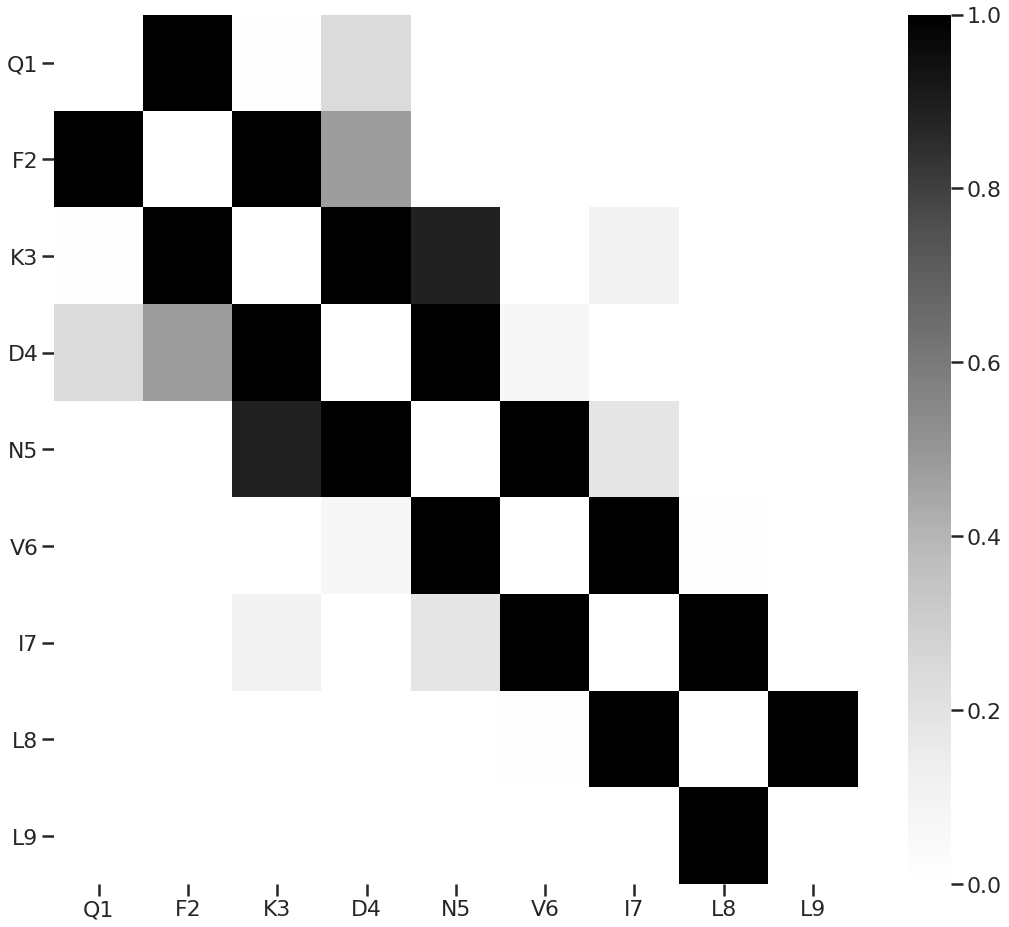

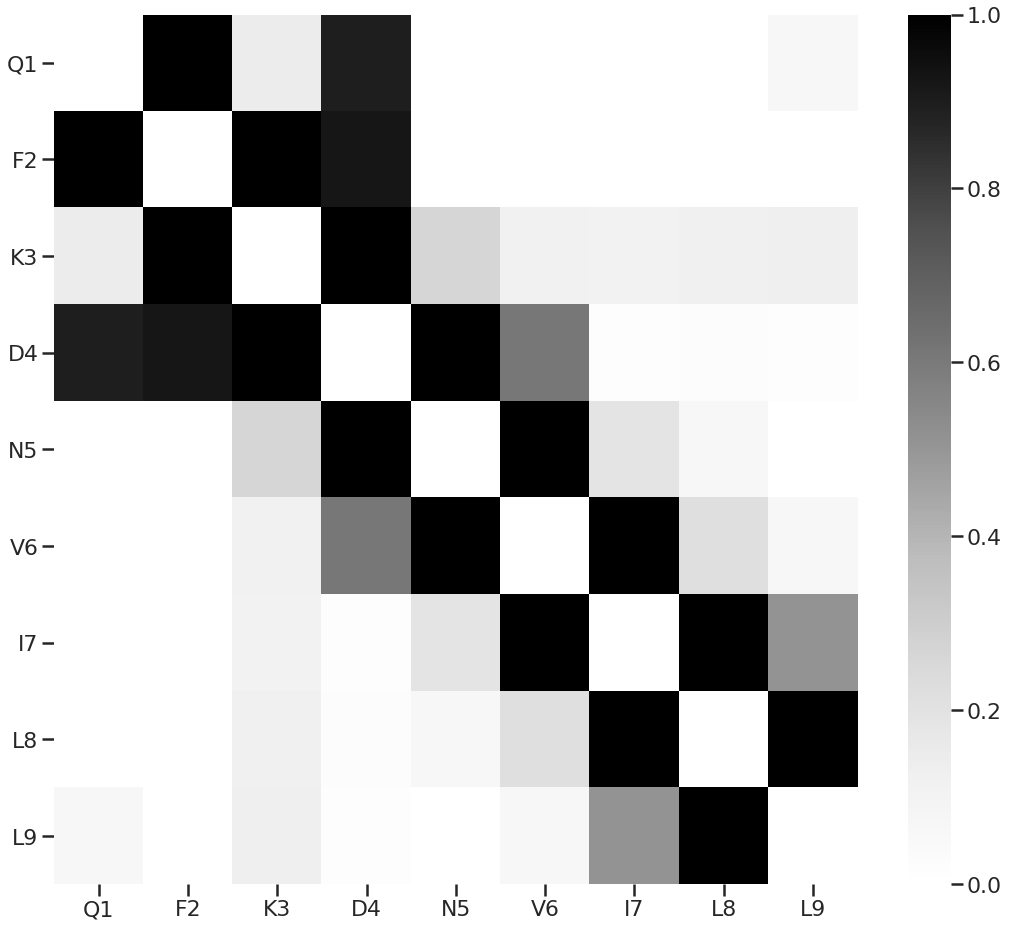

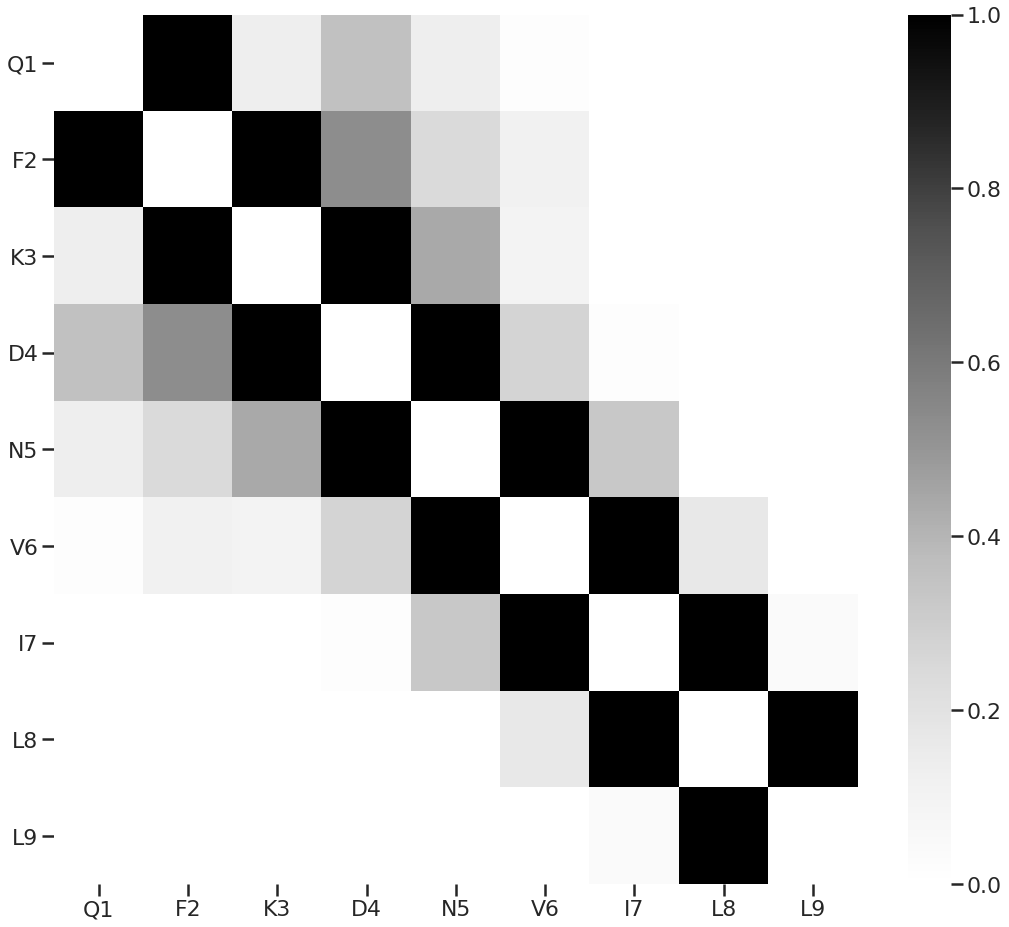

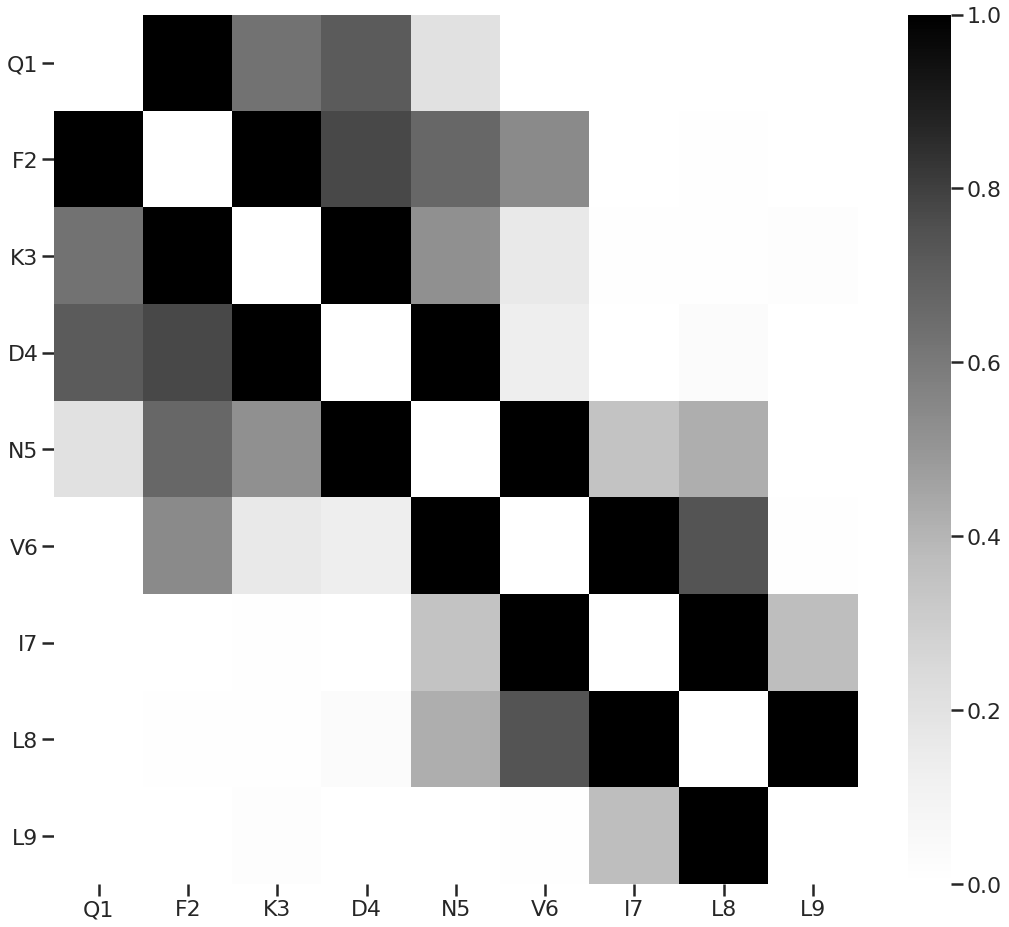

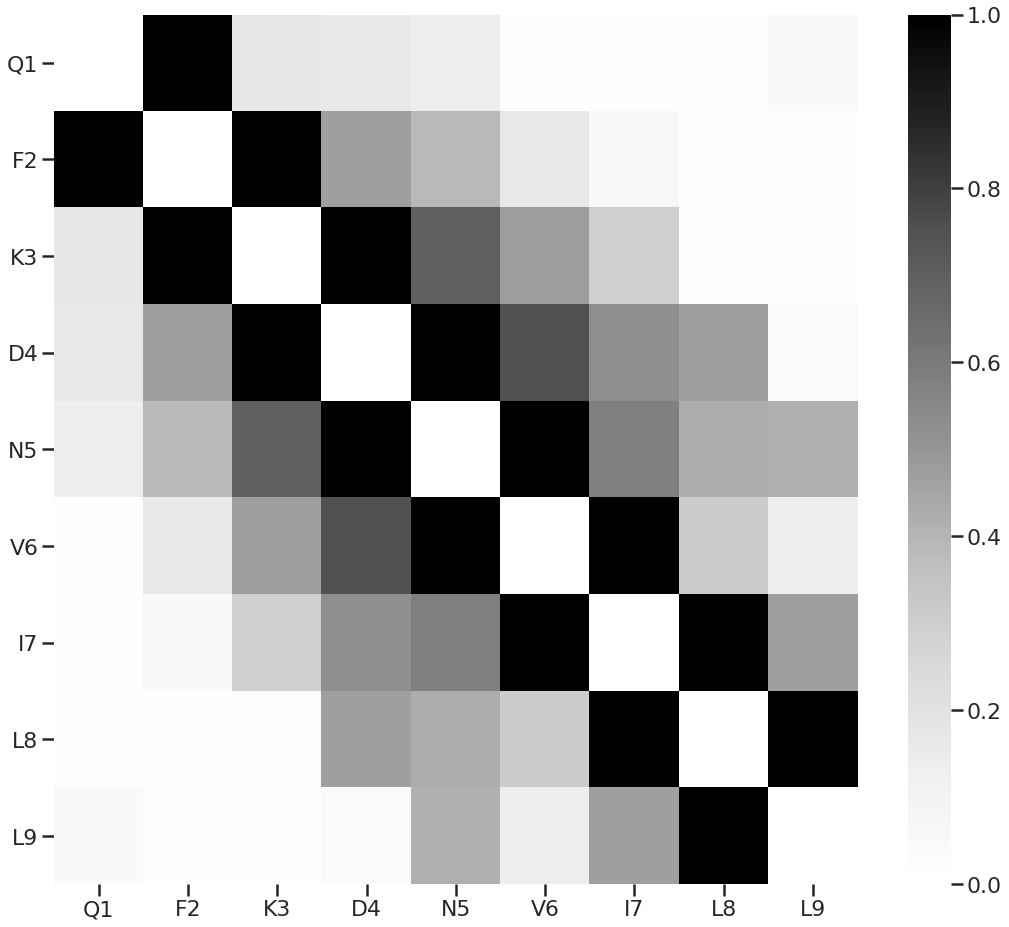

In [18]:
sns.set_context("poster")
one_letter_code = {'ARG':'R', 'HIS':'H', 'LYS':'K', 'ASP':'D', 'GLU':'E', \
                  'SER':'S', 'THR':'T', 'ASN':'N', 'GLN':'Q', 'CYS':'C', \
                  'GLY':'G', 'PRO':'P', 'ALA':'A', 'VAL':'V', 'ILE':'I', \
                  'LEU':'L', 'MET':'M', 'PHE':'F', 'TYR':'Y', 'TRP':'W'}
for i in range(5):
    fig = plt.figure(figsize=(18, 16))
    print("Macrostate", i)
    contacts_per_residue = [[] for j in range(9)]
    weights_per_residue = [[] for j in range(9)]
    interactions_per_residue = [np.zeros((9,)) for j in range(9)]
    mhc_res = ["" for j in range(9)]
    #mhc_toinclude = []
    for k in range(len(every_contact)):
        #if contact_macro_p_list[k][i] > 0.01: print(every_contact[k], contact_macro_p_list[k][i])
        resi_num = int(every_contact[k][3]) - 1
        mhc_num = int(every_contact[k][10:]) - 1
        mhc_label = every_contact[k][7:10]
        mhc_res[mhc_num] = one_letter_code[mhc_label] + str(mhc_num + 1)
        interactions_per_residue[resi_num][mhc_num] = contact_macro_p_list[k][i]
        contacts_per_residue[resi_num].append(every_contact[k])
        weights_per_residue[resi_num].append(contact_macro_p_list[k][i])
    for j in range(9):
        contacts_in_residue = np.array(contacts_per_residue[j])
        weights_in_residue = np.array(weights_per_residue[j])
        #print(j)
        sorted_indices = np.argsort(weights_in_residue)
        #print(contacts_in_residue[sorted_indices[-10:]], weights_in_residue[sorted_indices[-10:]])
        
    interactions = np.array(interactions_per_residue).T
    
    to_remove = []
    new_labels = []
    for j in range(len(interactions)):
        if np.sum(interactions[j]) < 0.01: to_remove.append(j)
        else: new_labels.append(mhc_res[j])
    interactions = np.delete(interactions, to_remove, 0)
    
    #print(interactions.shape)
    #cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(interactions, cmap="Greys", vmin=0, vmax=1)
    plt.xticks(np.arange(9)+0.5, ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"])
    plt.yticks(np.arange(len(new_labels)) + 0.5, new_labels, rotation="horizontal")
    #plt.savefig('/home/jabella/Downloads/' + mode + '/contact_prob_macro' + str(i) + '.png', dpi=500)
    #break

In [43]:
if not os.path.exists("contact_prob.npz"):
    print("Computing contacts")
    is_contact = []
    for i in global_traj_indices:
        if i%10 == 0: print(i)
        i_str = str(i).zfill(4)    
        x = np.load(i_str + "/pep_to_MHC/Y.npy")
        #print(x.shape, x[:,pep_mhc_indices].shape)
        is_contact.append(x[:,pep_mhc_indices] < 0.35)

    print("Organizing")
    contacts_per_macrostate = [[] for i in range(5)]
    from collections import defaultdict
    contact_macro_p = defaultdict(lambda: np.zeros((5,)))
    for cluster_index in range(len(index_clusters)):
        print(cluster_index)
        if cluster_index not in active_set: continue
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        num_conf_in_cluster = len(index_clusters[cluster_index])
        conf_prob = (mu[MSM_cluster_index]/num_conf_in_cluster) / macro_p[state_to_macrostate[MSM_cluster_index]]
        for trajindex, frameindex in index_clusters[cluster_index]:
            all_contacts = feat_des[pep_mhc_indices][is_contact[trajindex][frameindex]]
            #contacts_per_macrostate[state_to_macrostate[MSM_cluster_index]] = np.concatenate((contacts_per_macrostate[state_to_macrostate[MSM_cluster_index]], all_contacts), axis=0)
            #contacts_per_macrostate[state_to_macrostate[MSM_cluster_index]] += list(all_contacts)
            #pep_res = list(set([c[25:].split("-")[0].strip() for c in all_contacts]))
            #mhc_res = list(set([c[25:].split("-")[1].strip() for c in all_contacts]))
            for c in all_contacts: contact_macro_p[c][state_to_macrostate[MSM_cluster_index]] += conf_prob
            #for pr in pep_res: pep_contact_macro_p[pr][state_to_macrostate[MSM_cluster_index]] += conf_prob
            #for mr in mhc_res: mhc_contact_macro_p[mr][state_to_macrostate[MSM_cluster_index]] += conf_prob
         
    every_contact = []
    contact_macro_p_list = []
    for k in contact_macro_p.keys():
        every_contact.append(k[25:])
        contact_macro_p_list.append(contact_macro_p[k])
        
    np.savez_compressed("contact_prob.npz", every_contact=every_contact, contact_macro_p_list=contact_macro_p_list)

else:
    every_contact = np.load("contact_prob.npz", allow_pickle=True)["every_contact"]
    contact_macro_p_list = np.load("contact_prob.npz", allow_pickle=True)["contact_macro_p_list"]

Macrostate 0
Macrostate 1
Macrostate 2
Macrostate 3


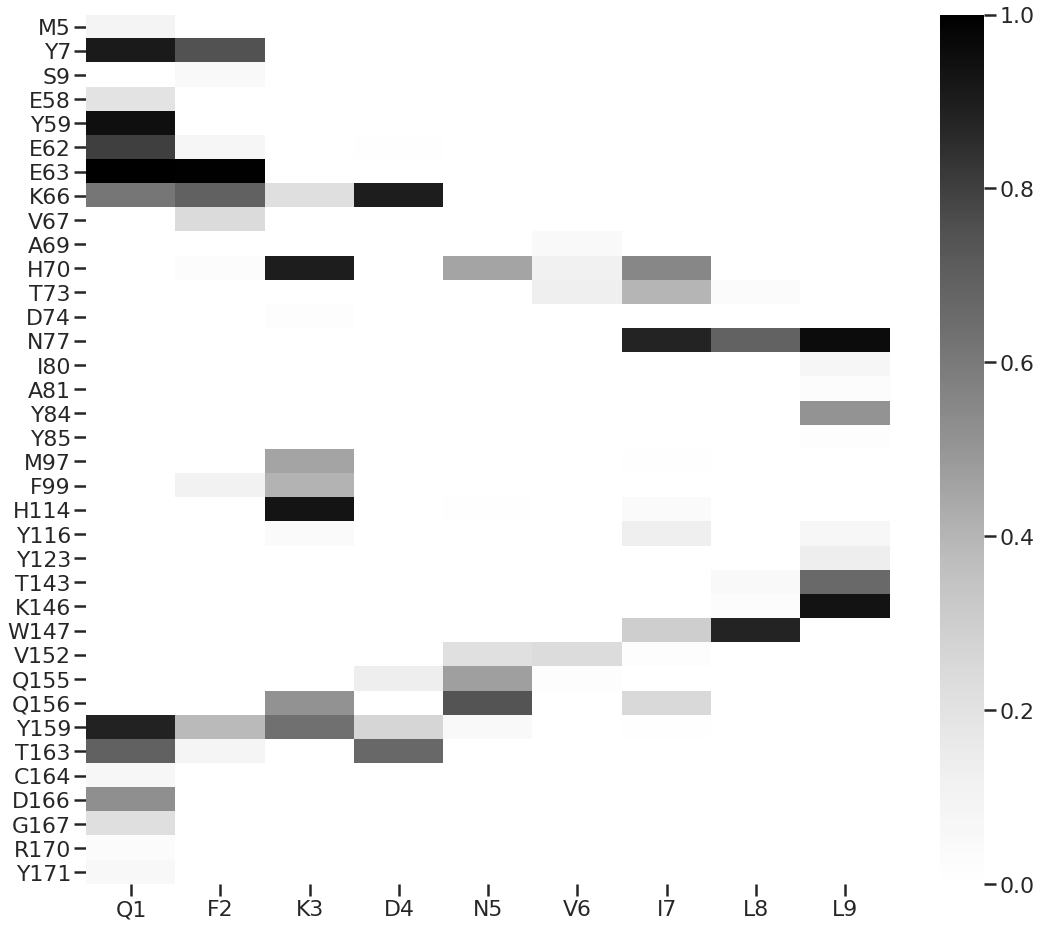

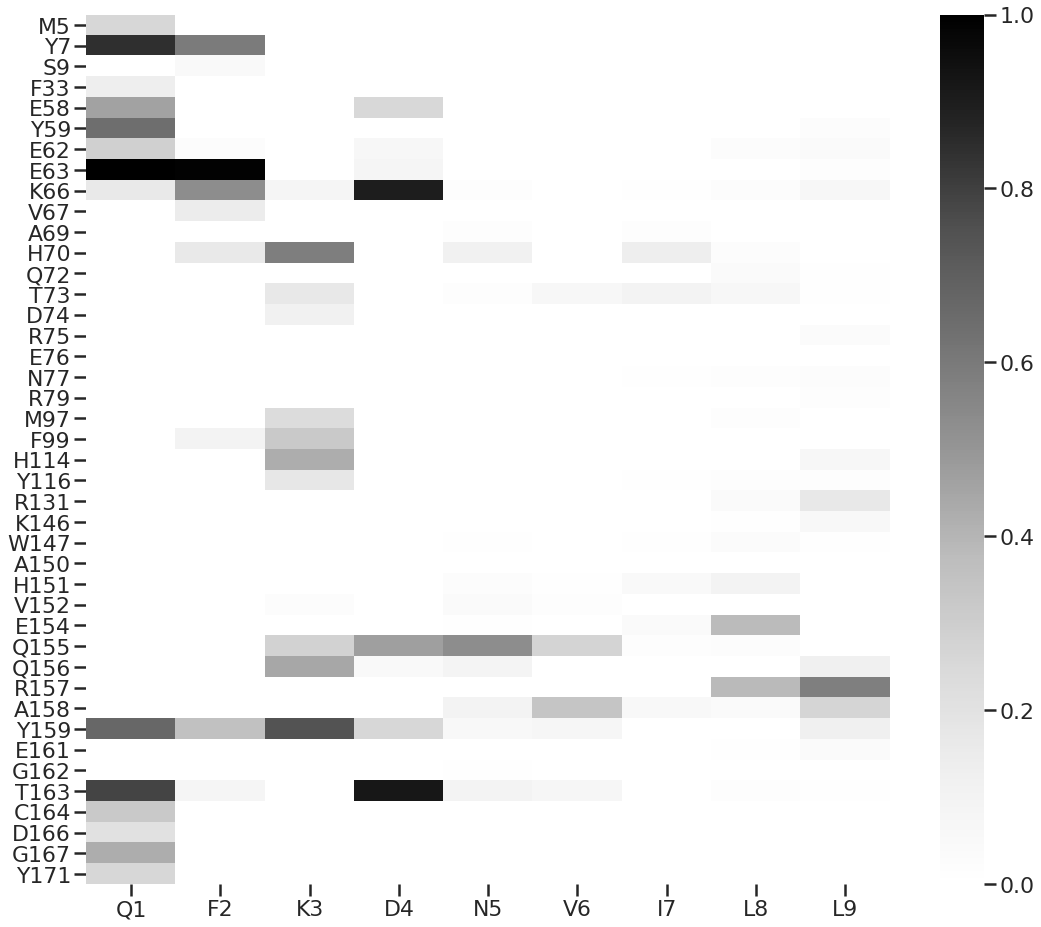

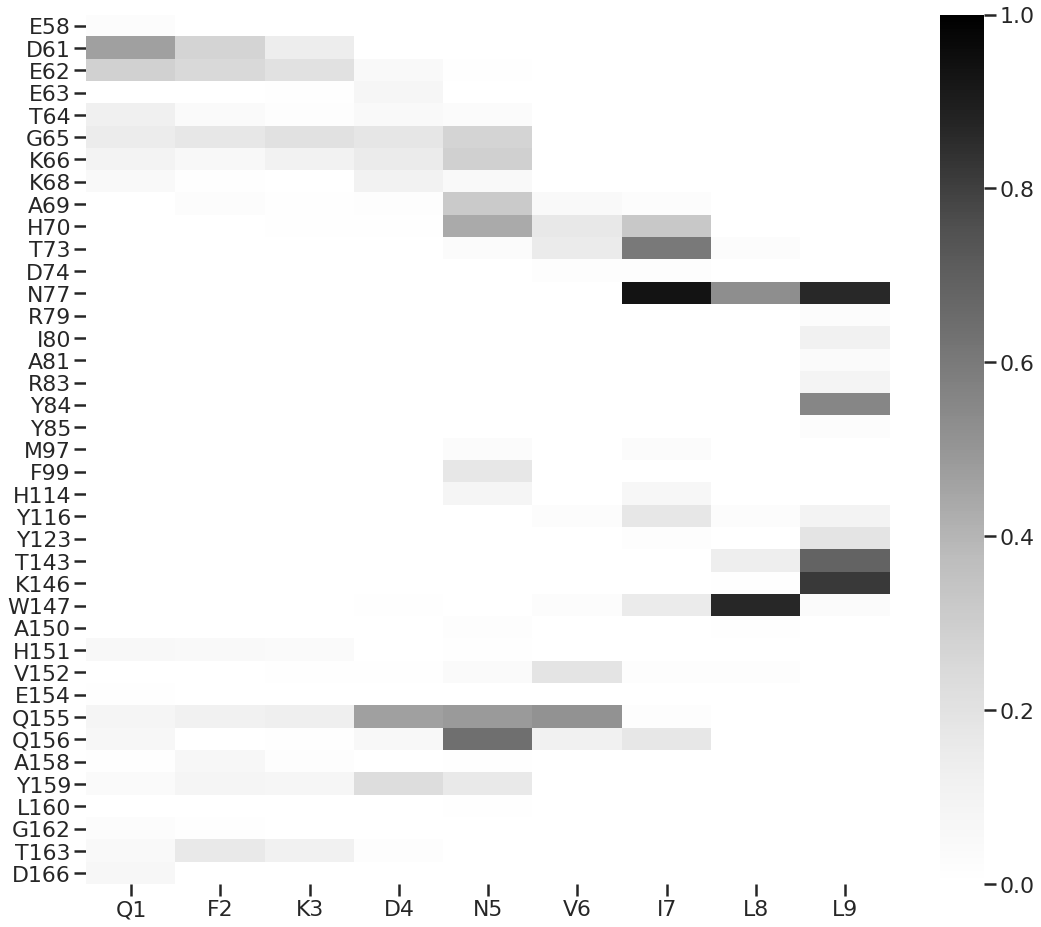

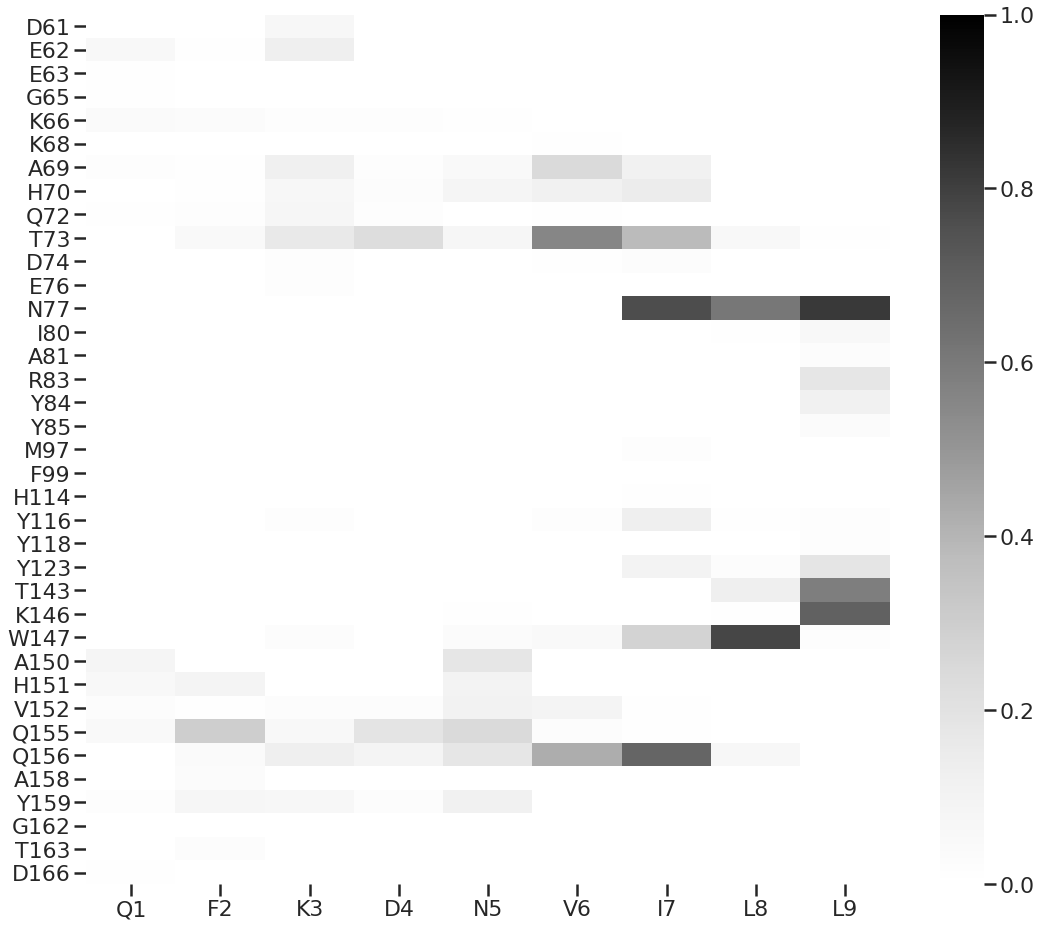

In [44]:
sns.set_context("poster")
one_letter_code = {'ARG':'R', 'HIS':'H', 'LYS':'K', 'ASP':'D', 'GLU':'E', \
                  'SER':'S', 'THR':'T', 'ASN':'N', 'GLN':'Q', 'CYS':'C', \
                  'GLY':'G', 'PRO':'P', 'ALA':'A', 'VAL':'V', 'ILE':'I', \
                  'LEU':'L', 'MET':'M', 'PHE':'F', 'TYR':'Y', 'TRP':'W'}
for i in range(4):
    fig = plt.figure(figsize=(18, 16))
    print("Macrostate", i)
    contacts_per_residue = [[] for j in range(9)]
    weights_per_residue = [[] for j in range(9)]
    interactions_per_residue = [np.zeros((180,)) for j in range(9)]
    mhc_res = ["" for j in range(180)]
    #mhc_toinclude = []
    for k in range(len(every_contact)):
        #if contact_macro_p_list[k][i] > 0.01: print(every_contact[k], contact_macro_p_list[k][i])
        resi_num = int(every_contact[k][3]) - 1
        mhc_num = int(every_contact[k][10:]) - 1
        mhc_label = every_contact[k][7:10]
        mhc_res[mhc_num] = one_letter_code[mhc_label] + str(mhc_num + 1)
        interactions_per_residue[resi_num][mhc_num] = contact_macro_p_list[k][i]
        contacts_per_residue[resi_num].append(every_contact[k])
        weights_per_residue[resi_num].append(contact_macro_p_list[k][i])
    for j in range(9):
        contacts_in_residue = np.array(contacts_per_residue[j])
        weights_in_residue = np.array(weights_per_residue[j])
        #print(j)
        sorted_indices = np.argsort(weights_in_residue)
        #print(contacts_in_residue[sorted_indices[-10:]], weights_in_residue[sorted_indices[-10:]])
        
    interactions = np.array(interactions_per_residue).T
    
    to_remove = []
    new_labels = []
    for j in range(len(interactions)):
        if np.sum(interactions[j]) < 0.01: to_remove.append(j)
        else: new_labels.append(mhc_res[j])
    interactions = np.delete(interactions, to_remove, 0)
    
    #print(interactions.shape)
    #cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(interactions, cmap="Greys", vmin=0, vmax=1)
    plt.xticks(np.arange(9)+0.5, ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"])
    plt.yticks(np.arange(len(new_labels)) + 0.5, new_labels, rotation="horizontal")
    plt.savefig('/home/jabella/Downloads/' + mode + '/contact_prob_macro' + str(i) + '.png', dpi=500)
    #break

In [40]:
if mode == "wild":
    bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states

    #bound_states = native_states
    dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
    dG_muts = []
    metastable_ddGs = []
    for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]:
        metastable_prob_wild = np.zeros((5,))
        metastable_prob_mut = np.zeros((5,))

        Z_wild_bound = 0
        Z_wild_unbound = 0
        Z_mut_bound = 0
        Z_mut_unbound = 0
        beta = 1. / RT
        num_confs_per_cluster = [len(ic) for ic in index_clusters]
        dEnergy = []
        for i, traj in enumerate(dtrajs):
            global_traj_index = global_traj_indices[i]

            wild_energies = []
            f = open(str(global_traj_index).zfill(4) + "/energies/wild.txt", 'r')
            for line in f:
                line_arr = line.split()
                wild_energies.append(float(line_arr[0]))
                #if float(line_arr[0]) > 0: print float(line_arr[0])
            f.close()

            mut_energies = []
            f = open(str(global_traj_index).zfill(4) + "/energies/" + mutant + ".txt", 'r')
            for line in f:
                line_arr = line.split()
                mut_energies.append(float(line_arr[0]))
            f.close()
            cluster_assignments_in_traj = traj[::25]
            #if len(traj)-len(mut_energies) == 1: cluster_assignments_in_traj = cluster_assignments_in_traj[:-1]

            wild_energies = np.array(wild_energies)
            mut_energies = np.array(mut_energies)

            for j,cluster_index in enumerate(cluster_assignments_in_traj):
                if cluster_index not in active_set: continue

                MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
                wild_val = mu[MSM_cluster_index] / num_confs_per_cluster[cluster_index]
                reweighting_factor = np.exp( beta * (wild_energies[j] - mut_energies[j]) )

                if np.isinf(reweighting_factor): 
                    print(i, j, cluster_index, wild_energies[j], mut_energies[j])
                    continue

                dEnergy.append(wild_energies[j] - mut_energies[j])

                mut_val = reweighting_factor*wild_val
                if MSM_cluster_index in bound_states:
                    Z_wild_bound += wild_val
                    Z_mut_bound += mut_val
                elif MSM_cluster_index in unbound_states:
                    Z_wild_unbound += wild_val
                    Z_mut_unbound += mut_val

                metastable_prob_wild[state_to_macrostate[MSM_cluster_index]] += wild_val
                metastable_prob_mut[state_to_macrostate[MSM_cluster_index]] += mut_val


        #print(Z_wild_bound, Z_wild_unbound)
        #print(Z_mut_bound, Z_mut_unbound)
        #print(Z_wild_bound / Z_wild_unbound, Z_mut_unbound / Z_mut_bound, (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound))
        #print(Z_wild_unbound / Z_wild_bound, Z_mut_unbound / Z_mut_bound)
        #print(RT*np.log( (Z_wild_unbound / Z_wild_bound)))
        ddG = RT*np.log( (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound) )
        dG_mut = RT*np.log(Z_mut_unbound / Z_mut_bound)
        dG_wild = RT*np.log(Z_wild_unbound / Z_wild_bound)

        if dG_mut > 0: outputlabel = "weaker binder, non binder"
        elif abs(ddG) < 0.1: outputlabel = "similar binder"
        elif dG_wild < dG_mut: outputlabel = "weaker binder"
        elif dG_wild > dG_mut: outputlabel = "stronger binder"
        else: outputlabel = "nan"
        print(mutant, ddG, outputlabel)
        print(ddG, dG, dG_wild, dG_mut)
        #print(Z_wild_bound, Z_wild_unbound)
        #print(metastable_prob_wild)
        #print(Z_mut_bound, Z_mut_unbound)
        #print(metastable_prob_mut)
        metastable_ddGs_mut = RT*np.log( (metastable_prob_wild / Z_wild_unbound) * (Z_mut_unbound / metastable_prob_mut) )
        metastable_ddGs.append(metastable_ddGs_mut)
        print(metastable_ddGs_mut)
        dG_muts.append(dG_mut)

Q1 5.794252138032308 weaker binder
5.794252138032308 -7.192959516675874 -7.181412149360615 -1.3871600113283071
[29.65169764 33.97960442 -2.93113208 -0.21046449  0.        ]
F2 15.44347392077479 weaker binder, non binder
15.44347392077479 -7.192959516675874 -7.181412149360615 8.262061771414174
[38.74708599 37.73001047  7.25686425  6.70205932  0.        ]
K3 0.0025816845453295514 similar binder
0.0025816845453295514 -7.192959516675874 -7.181412149360615 -7.178830464815286
[18.80720125 -8.49964184 -8.05754268 -2.19985972  0.        ]
D4 11.367469885201515 weaker binder, non binder
11.367469885201515 -7.192959516675874 -7.181412149360615 4.186057735840899
[14.8801344  17.53094207  3.48685187  4.62164578  0.        ]
N5 5.565155078502523 weaker binder
5.565155078502523 -7.192959516675874 -7.181412149360615 -1.6162570708580943
[ 5.48694143  5.7794595  12.95833297  7.50940729  0.        ]
V6 1.499771458335809 weaker binder
1.499771458335809 -7.192959516675874 -7.181412149360615 -5.68164069102

In [41]:
if mode == "wild":
    bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states

    #bound_states = native_states
    dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
    dG_muts = []
    metastable_ddGs = []
    for mutant in ["K66", "Q155", "Y159"]:
        metastable_prob_wild = np.zeros((5,))
        metastable_prob_mut = np.zeros((5,))

        Z_wild_bound = 0
        Z_wild_unbound = 0
        Z_mut_bound = 0
        Z_mut_unbound = 0
        beta = 1. / RT
        num_confs_per_cluster = [len(ic) for ic in index_clusters]
        dEnergy = []
        for i, traj in enumerate(dtrajs):
            global_traj_index = global_traj_indices[i]

            wild_energies = []
            f = open(str(global_traj_index).zfill(4) + "/energies/wild.txt", 'r')
            for line in f:
                line_arr = line.split()
                wild_energies.append(float(line_arr[0]))
                #if float(line_arr[0]) > 0: print float(line_arr[0])
            f.close()

            mut_energies = []
            f = open(str(global_traj_index).zfill(4) + "/energies/" + mutant + ".txt", 'r')
            for line in f:
                line_arr = line.split()
                mut_energies.append(float(line_arr[0]))
            f.close()
            cluster_assignments_in_traj = traj[::25]
            #if len(traj)-len(mut_energies) == 1: cluster_assignments_in_traj = cluster_assignments_in_traj[:-1]

            wild_energies = np.array(wild_energies)
            mut_energies = np.array(mut_energies)

            for j,cluster_index in enumerate(cluster_assignments_in_traj):
                if cluster_index not in active_set: continue

                MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
                wild_val = mu[MSM_cluster_index] / num_confs_per_cluster[cluster_index]
                reweighting_factor = np.exp( beta * (wild_energies[j] - mut_energies[j]) )

                if np.isinf(reweighting_factor): 
                    print(i, j, cluster_index, wild_energies[j], mut_energies[j])
                    continue

                dEnergy.append(wild_energies[j] - mut_energies[j])

                mut_val = reweighting_factor*wild_val
                if MSM_cluster_index in bound_states:
                    Z_wild_bound += wild_val
                    Z_mut_bound += mut_val
                elif MSM_cluster_index in unbound_states:
                    Z_wild_unbound += wild_val
                    Z_mut_unbound += mut_val

                metastable_prob_wild[state_to_macrostate[MSM_cluster_index]] += wild_val
                metastable_prob_mut[state_to_macrostate[MSM_cluster_index]] += mut_val


        #print(Z_wild_bound, Z_wild_unbound)
        #print(Z_mut_bound, Z_mut_unbound)
        #print(Z_wild_bound / Z_wild_unbound, Z_mut_unbound / Z_mut_bound, (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound))
        #print(Z_wild_unbound / Z_wild_bound, Z_mut_unbound / Z_mut_bound)
        #print(RT*np.log( (Z_wild_unbound / Z_wild_bound)))
        ddG = RT*np.log( (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound) )
        dG_mut = RT*np.log(Z_mut_unbound / Z_mut_bound)
        dG_wild = RT*np.log(Z_wild_unbound / Z_wild_bound)

        if dG_mut > 0: outputlabel = "weaker binder, non binder"
        elif abs(ddG) < 0.1: outputlabel = "similar binder"
        elif dG_wild < dG_mut: outputlabel = "weaker binder"
        elif dG_wild > dG_mut: outputlabel = "stronger binder"
        else: outputlabel = "nan"
        print(mutant, ddG, outputlabel)
        print(ddG, dG, dG_wild, dG_mut)
        #print(Z_wild_bound, Z_wild_unbound)
        #print(metastable_prob_wild)
        #print(Z_mut_bound, Z_mut_unbound)
        #print(metastable_prob_mut)
        metastable_ddGs_mut = RT*np.log( (metastable_prob_wild / Z_wild_unbound) * (Z_mut_unbound / metastable_prob_mut) )
        metastable_ddGs.append(metastable_ddGs_mut)
        print(metastable_ddGs_mut)
        dG_muts.append(dG_mut)

K66 -2.9465929107406876 stronger binder
-2.9465929107406876 -7.192959516675874 -7.181412149360615 -10.128005060101303
[-2.94570014 -5.25990775 -2.13628017  1.08173217  0.        ]
Q155 -0.6429946903104445 stronger binder
-0.6429946903104445 -7.192959516675874 -7.181412149360615 -7.82440683967106
[-0.71498703  3.54124047  2.58505054 -0.29172692  0.        ]
Y159 11.561911994266268 weaker binder, non binder
11.561911994266268 -7.192959516675874 -7.181412149360615 4.3804998449056525
[27.30974894 29.67867448  2.7629178   6.54737903  0.        ]


In [38]:
if mode == "wild":
    f = open("/home/jabella/Downloads/" + mode + "/metastable_ddGs.csv", 'w')
    metastable_ddGs = np.array(metastable_ddGs)
    print(metastable_ddGs.shape)
    labels = ["Macrostate","Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]
    print(",".join(labels))
    f.write(",".join(labels))
    f.write("\n")
    for i in range(4):
        mddGs_str = [str(i)] + ["%.1f"%g for g in metastable_ddGs[:,i]]
        print(",".join(mddGs_str))
        f.write(",".join(mddGs_str))
        f.write("\n")
    f.close()

(9, 5)
Macrostate,Q1,F2,K3,D4,N5,V6,I7,L8,L9
0,29.7,38.7,18.8,14.9,5.5,1.5,7.7,-0.1,19.8
1,34.0,37.7,-8.5,17.5,5.8,0.4,-2.9,-3.0,1.1
2,-2.9,7.3,-8.1,3.5,13.0,3.3,9.7,-1.0,15.9
3,-0.2,6.7,-2.2,4.6,7.5,-0.0,7.3,4.8,8.7


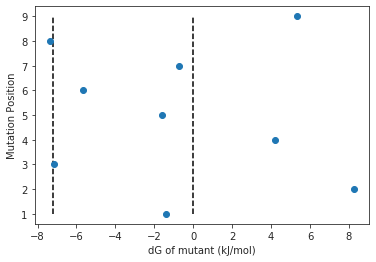

In [39]:
if mode == "wild":
    mutants = ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]
    X = []
    xerrs = []
    Y = []
    for i,mut in enumerate(dG_muts):
        X.append(np.mean(mut))
        xerrs.append(np.std(mut))
        Y.append(i+1)
    plt.errorbar(X,Y, xerr=xerrs, fmt="o")
    plt.plot(9*[dG], np.arange(1,10), "--", c="black")
    plt.plot(9*[0], np.arange(1,10), "--", c="black")
    plt.xlabel("dG of mutant (kJ/mol)")
    plt.ylabel("Mutation Position")
    plt.savefig('/home/jabella/Downloads/ddG_newdata.png', dpi=1200)

In [40]:
#nstates = 8
bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states

#bound_states = native_states
dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
dG_muts = []
dEnergy = {}
for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]: 
    dEnergy[mutant] = [[] for _ in range(len(mu))]
for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]:

    for i, traj in enumerate(dtrajs):
        global_traj_index = global_traj_indices[i]
        
        wild_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/wild.txt", 'r')
        for line in f:
            line_arr = line.split()
            wild_energies.append(float(line_arr[0]))
            #if float(line_arr[0]) > 0: print float(line_arr[0])
        f.close()
        
        mut_energies = []
        f = open(str(global_traj_index).zfill(4) + "/energies/" + mutant + ".txt", 'r')
        for line in f:
            line_arr = line.split()
            mut_energies.append(float(line_arr[0]))
        f.close()
        cluster_assignments_in_traj = traj[::25]
        #if len(traj)-len(mut_energies) == 1: cluster_assignments_in_traj = cluster_assignments_in_traj[:-1]

        wild_energies = np.array(wild_energies)
        mut_energies = np.array(mut_energies)

        for j,cluster_index in enumerate(cluster_assignments_in_traj):
            if cluster_index not in active_set: continue

            MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
            #wild_val = mu[MSM_cluster_index] / num_confs_per_cluster[cluster_index]
            reweighting_factor = np.exp( beta * (wild_energies[j] - mut_energies[j]) )
            
            dEnergy[mutant][MSM_cluster_index].append(reweighting_factor)
            

for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]: 
    dEnergy[mutant] = np.array(dEnergy[mutant])           
print(dEnergy["Q1"].shape)

(100,)


In [41]:

N = 5000
dG_muts = []
for mutant in ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]:
    dG_mut_sample = []
    for i in range(10):
        Z_wild_bound = 0
        Z_wild_unbound = 0
        Z_mut_bound = 0
        Z_mut_unbound = 0
        beta = 1. / RT
        for MSM_cluster_index in range(len(mu)):
            wild_val = mu[MSM_cluster_index]
            vals_in_cluster = np.array(dEnergy[mutant][MSM_cluster_index])
            random_subset = np.random.choice(vals_in_cluster, size=N, replace=True)
            reweighting_factor = np.mean(random_subset)
            mut_val = reweighting_factor*wild_val
            if MSM_cluster_index in bound_states:
                Z_wild_bound += wild_val
                Z_mut_bound += mut_val
            elif MSM_cluster_index in unbound_states:
                Z_wild_unbound += wild_val
                Z_mut_unbound += mut_val

        ddG = RT*np.log( (Z_wild_bound / Z_wild_unbound) * (Z_mut_unbound / Z_mut_bound) )
        dG_mut = RT*np.log(Z_mut_unbound / Z_mut_bound)
        dG_wild = RT*np.log(Z_wild_unbound / Z_wild_bound)

        #if dG_mut > 0: outputlabel = "weaker binder, non binder"
        #elif abs(ddG) < 0.1: outputlabel = "similar binder"
        #elif dG_wild < dG_mut: outputlabel = "weaker binder"
        #elif dG_wild > dG_mut: outputlabel = "stronger binder"
        #else: outputlabel = "nan"
        #print(mutant, ddG, outputlabel)
        #print(ddG, dG, dG_wild, dG_mut)
        dG_mut_sample.append(dG_mut)
    dG_muts.append(dG_mut_sample)

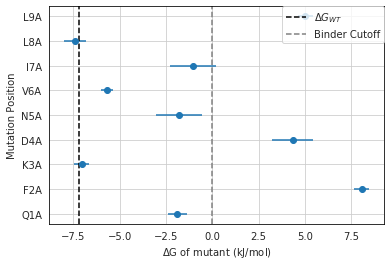

In [73]:
sns.set_style("whitegrid", {"axes.edgecolor": "0.0"})
mutants = ["Q1A", "F2A", "K3A", "D4A", "N5A", "V6A", "I7A", "L8A", "L9A"]
X = []
xerrs = []
Y = []
for i,mut in enumerate(dG_muts):
    X.append(np.mean(mut))
    xerrs.append(np.std(mut))
    #Y.append(i+1)
    Y.append(mutants[i])
plt.errorbar(X,Y, xerr=xerrs, fmt="o")
#plt.plot(11*[dG], [0.5] + [i for i in range(1,10)] + [9.5], "--", c="black")
#plt.plot(11*[0], [0.5] + [i for i in range(1,10)] + [9.5], "--", c="black")
plt.axvline(x=dG, ymin=0, ymax=1, c="black", linestyle="--", label="$\Delta G_{WT}$")
plt.axvline(x=0, ymin=0, ymax=1, c="gray", linestyle="--", label="Binder Cutoff")
plt.xlabel("$\Delta$G of mutant (kJ/mol)")
plt.ylabel("Mutation Position")
plt.legend(loc='upper right', borderaxespad=0.)
#plt.savefig('/home/jabella/Downloads/' + mode + '/ddG.png', dpi=500)

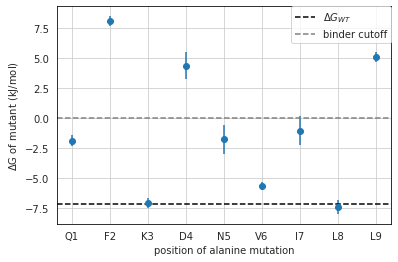

In [78]:
sns.set_style("whitegrid", {"axes.edgecolor": "0.0"})
mutants = ["Q1", "F2", "K3", "D4", "N5", "V6", "I7", "L8", "L9"]
X = []
yerrs = []
Y = []
for i,mut in enumerate(dG_muts):
    Y.append(np.mean(mut))
    yerrs.append(np.std(mut))
    #X.append(i+1)
    X.append(mutants[i])
plt.errorbar(X,Y, yerr=yerrs, fmt="o")
#plt.plot(11*[dG], [0.5] + [i for i in range(1,10)] + [9.5], "--", c="black")
#plt.plot(11*[0], [0.5] + [i for i in range(1,10)] + [9.5], "--", c="black")
plt.axhline(y=dG, xmin=0, xmax=1, c="black", linestyle="--", label="$\Delta G_{WT}$")
plt.axhline(y=0, xmin=0, xmax=1, c="gray", linestyle="--", label="binder cutoff")
plt.ylabel("$\Delta$G of mutant (kJ/mol)")
plt.xlabel("position of alanine mutation")
plt.legend(loc='upper right', borderaxespad=0.)
plt.savefig('/home/jabella/Downloads/' + mode + '/ddG.png', dpi=500)

In [36]:
# get network of unbiased state
active_set = MSM.active_set
mu = MSM.stationary_distribution
nstates = MSM.nstates

# state definitions
unbound_states = []
associated_states = []
native_states = []
cterm_bound_states = []
nterm_bound_states = []
anchor_cutoff = 0.2
state_to_macrostate = []
print(nstates, len(active_set))
for MSM_state in range(nstates):
    cluster_index = active_set[MSM_state]
    nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
    #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(MSM_state)
    if cluster_feats_r[cluster_index] < 0.2: 
        native_states.append(MSM_state)
        state_to_macrostate.append(0)
    elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
        cterm_bound_states.append(MSM_state)
        state_to_macrostate.append(2)
    elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
        nterm_bound_states.append(MSM_state)
        state_to_macrostate.append(1)
    #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
    elif cluster_feats[cluster_index] > 0.5: 
        unbound_states.append(MSM_state)
        state_to_macrostate.append(4)
    else: 
        associated_states.append(MSM_state)
        state_to_macrostate.append(3)
#print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)
print(len(unbound_states))

88 88
7


In [37]:
# plot network
mfpt = np.zeros((5, 5))
metastable_sets = [native_states,nterm_bound_states,cterm_bound_states,associated_states,unbound_states]
bound_states = native_states+nterm_bound_states+cterm_bound_states+associated_states
for i in range(5):
    for j in range(5):
        mfpt[i, j] = steps_to_nanoseconds*(1/1E6)*MSM.mfpt(
            metastable_sets[i],
            metastable_sets[j])
        #if i == j:
        #    mfpt[i,j] = 0
        #    continue
        #mfpt[i,j] = pyemma.msm.tpt(MSM, metastable_sets[i], metastable_sets[j]).flux

mfpt[3,4] = steps_to_nanoseconds*(1/1E6)*MSM.mfpt(bound_states, unbound_states)
mfpt[4,3] = steps_to_nanoseconds*(1/1E6)*MSM.mfpt(unbound_states, bound_states)

        
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

#inverse_mfpt[inverse_mfpt > 0.01] = 1.0
#inverse_mfpt[inverse_mfpt < 0.01] = 0.1

inverse_mfpt[0,3] = 0
inverse_mfpt[0,4] = 0
inverse_mfpt[1,2] = 0
inverse_mfpt[1,4] = 0
inverse_mfpt[2,1] = 0
inverse_mfpt[2,4] = 0
inverse_mfpt[3,0] = 0
inverse_mfpt[4,0] = 0
inverse_mfpt[4,1] = 0
inverse_mfpt[4,2] = 0

#print(inverse_mfpt)
#print(mfpt)

In [38]:
print(MSM.nstates, MSM.stationary_distribution.shape, MSM.active_set.shape)
MSM.stationary_distribution = MSM.stationary_distribution[MSM.active_set] / np.sum(MSM.stationary_distribution[MSM.active_set])


88 (100,) (88,)


In [39]:
print(macro_p)

[0.9062018031626362, 0.008699018851014758, 0.0255632672659701, 0.007459256359458443, 0.05207665436092025]


(88, 88)
[[0.         0.71407495 0.28592505 0.         0.        ]
 [0.         0.         0.         0.71407724 0.        ]
 [0.         0.         0.         0.         0.32919141]
 [0.         0.         0.04326656 0.         0.67080844]
 [0.         0.         0.         0.         0.        ]]


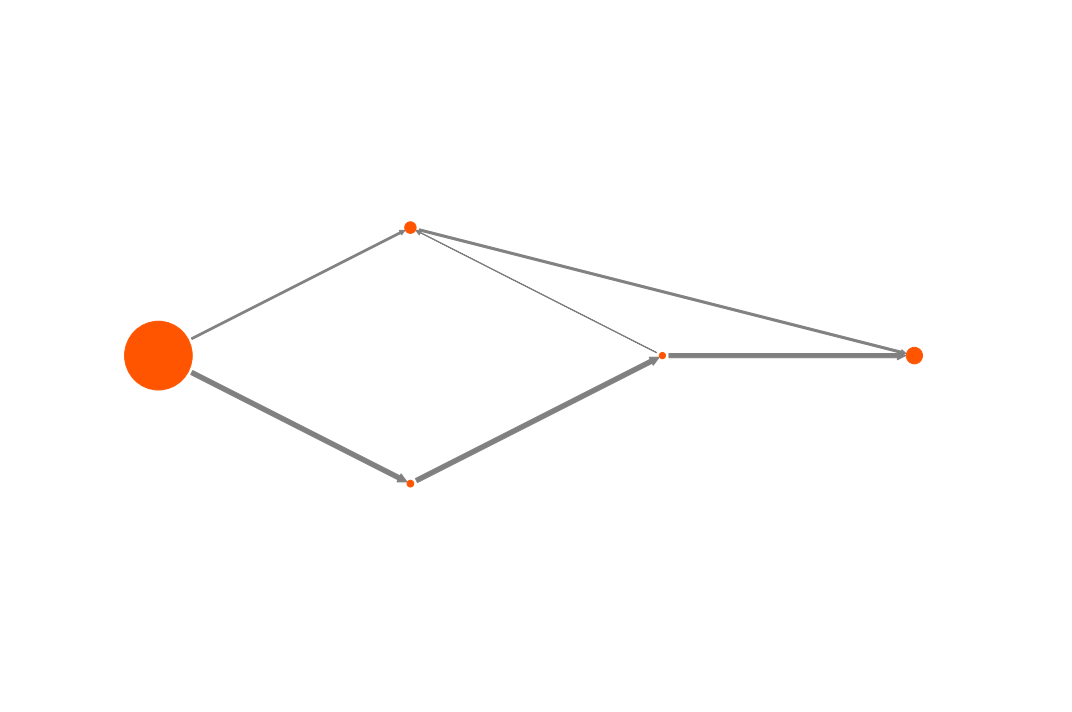

In [50]:
t = pyemma.msm.tpt(MSM, native_states, unbound_states)
#t = pyemma.msm.tpt(MSM, unbound_states, native_states)
print(t.flux.shape)
cg, cgflux = t.coarse_grain(metastable_sets)

#cgflux.flux /= np.sum(cgflux.flux[0])
#print(cgflux.flux)
print(1.0/np.sum(cgflux.flux[0,:]) * cgflux.flux)
fig, ax = plt.subplots(figsize=(15, 10))
macro_p_visual = np.array(macro_p)
macro_p = np.array(macro_p)
if mode == "wild": macro_p_visual[1:] += 0.1
if mode == "D4A": macro_p_visual[:-1] += 0.05
pyemma.plots.plot_flux(cgflux, flux_scale=1.0/np.sum(cgflux.flux[0,:]), pos=np.array([(0,0),(1,-0.5),(1,0.5),(2,0),(3,0)]), 
                       show_committor=False, ax=ax, arrow_labels=None, arrow_curvature=0.0,
                      state_labels=None, state_sizes=macro_p, minflux=0.0001,
                      size=20) #state_colors='#d9dddc', 

fij = 100.0/np.sum(cgflux.flux[0,:]) * cgflux.flux

"""
arrow_01 = ax.text(0.45,-0.2,'%2.f%%' % fij[0,1], size=20)
arrow_02 = ax.text(0.45,0.1,'%2.f%%' % fij[0,2], size=20)

arrow_13 = ax.text(1.3,-0.2,'%2.f%%' % fij[1,3], size=20)
if mode == "wild": arrow_32 = ax.text(1.3,0.1,'%2.f%%' % fij[3,2], size=20)
if mode == "D4A": arrow_23 = ax.text(1.3,0.1,'%2.f%%' % fij[2,3], size=20)

arrow_34 = ax.text(2.4,-0.15,'%2.f%%' % fij[3,4], size=20)

if mode == "wild": arrow_24 = ax.text(1.9,0.3,'%2.f%%' % fij[2,4], size=20)
"""

fig.tight_layout()


plt.savefig('/home/jabella/Downloads/' + mode + '/unbind.png')
plt.savefig('/home/jabella/Downloads/' + mode + '/unbind_hires.png', dpi=500)

(88, 88)
ReactiveFlux(A=[0], B=[4], dt_model=[TimeUnit 6250.0 step],
       flux=array([[0.00000e+00, 0.00000e+00, 2.05546e-11, 4.18851e-11, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.45866e-11],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 2.70154e-12, 1.78531e-11],
       [0.00000e+00, 4.45865e-11, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]]),
       gross_flux=array([[0.00000e+00, 0.00000e+00, 2.05546e-11, 4.18851e-11, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 5.85483e-11, 4.45866e-11],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 2.84428e-09, 1.78531e-11],
       [0.00000e+00, 1.03135e-10, 2.84158e-09, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]]),
       mu=array([0.00203, 0.00916, 0.02691, 0.00785, 0.95405]),
       qminus=array([1.     , 0.02007, 0.97345, 0.96815, 0.     ]),
       qplus=array([0.   

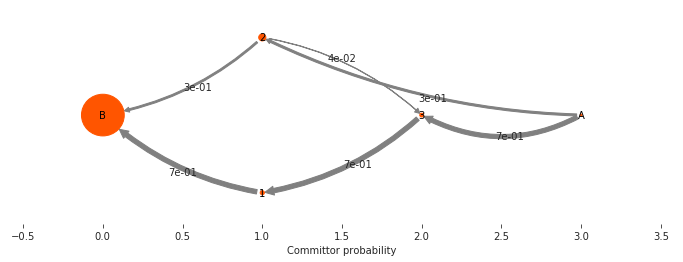

In [74]:
#t = pyemma.msm.tpt(MSM, native_states, unbound_states)
t = pyemma.msm.tpt(MSM, unbound_states, native_states)
print(t.flux.shape)
cg, cgflux = t.coarse_grain(metastable_sets)
pyemma.plots.plot_flux(cgflux, flux_scale=1.0/np.sum(cgflux.flux[0,:]), pos=np.array([(3,0),(1,-0.5),(1,0.5),(2,0),(0,0)]))
print(cgflux)
print(1E12 * cgflux.flux)
plt.savefig('/home/jabella/Downloads/' + mode + '/bind.png')

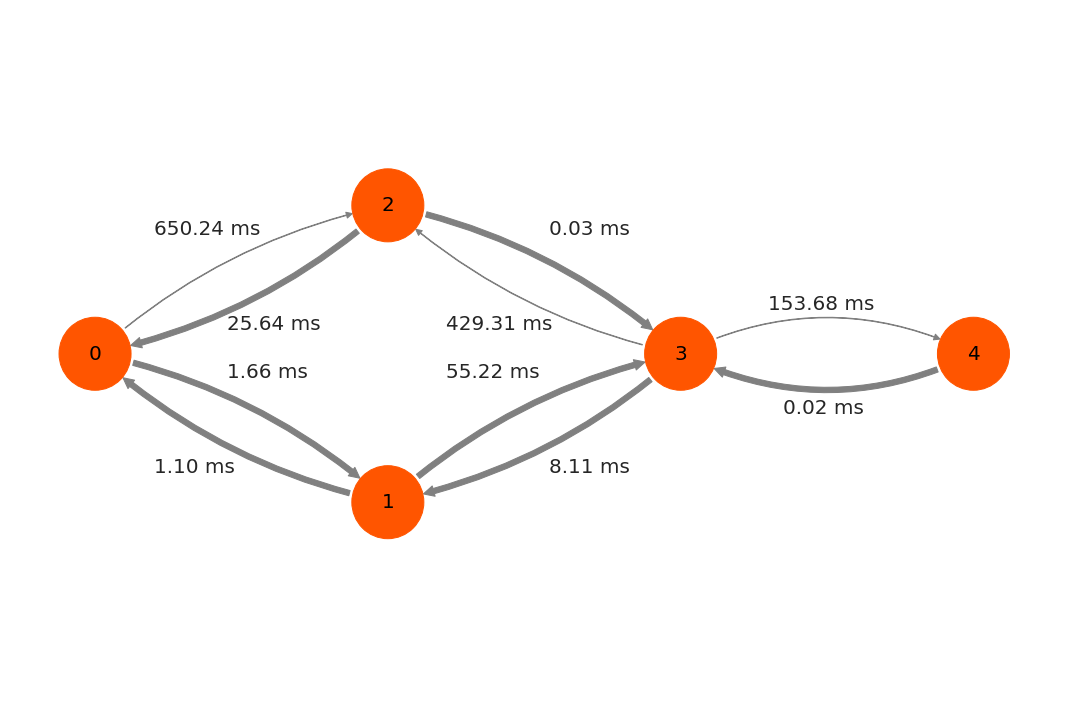

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))
pyemma.plots.plot_network(
    100000*inverse_mfpt,
    pos=np.array([(0,0),(1,-0.5),(1,0.5),(2,0),(3,0)]),
    #xpos=[0,1,2,3,4],
    figpadding=0.1,
    arrow_label_format='%.2f ms',
    #arrow_labels=mfpt,
    arrow_labels=None,
    arrow_scale=1.0,
    arrow_curvature=1.0,
    size=20,
    arrow_label_size=20,
    #state_labels=["%.3f" % pm for pm in macro_p],
    state_labels = np.arange(5),
    #state_sizes = np.array(macro_p),
    show_frame=False,
    ax=ax)

arrow_02 = ax.text(0.2,0.4,'%.2f ms' % mfpt[0,2], size=20)
arrow_23 = ax.text(1.55,0.4,'%.2f ms' % mfpt[2,3], size=20)

arrow_20 = ax.text(0.45,0.08,'%.2f ms' % mfpt[2,0], size=20)
arrow_32 = ax.text(1.2,0.08,'%.2f ms' % mfpt[3,2], size=20)

arrow_01 = ax.text(0.45,-0.08,'%.2f ms' % mfpt[0,1], size=20)
arrow_13 = ax.text(1.2,-0.08,'%.2f ms' % mfpt[1,3], size=20)

arrow_10 = ax.text(0.2,-0.4,'%.2f ms' % mfpt[1,0], size=20)
arrow_31 = ax.text(1.55,-0.4,'%.2f ms' % mfpt[3,1], size=20)

arrow_34 = ax.text(2.3,0.15,'%.2f ms' % mfpt[3,4], size=20)
arrow_43 = ax.text(2.35,-0.2,'%.2f ms' % mfpt[4,3], size=20)

fig.tight_layout()
#plt.savefig('/home/jabella/Downloads/' + mode + '/network_hires.png', dpi=1200)
#plt.savefig('/home/jabella/Downloads/' + mode + '/network.png')

In [70]:
# try cktest
#MSM_n = pyemma.msm.markov_model(MSM.P)
#cktest = MSM_n.cktest(2, mlags=None, err_est=False)
#pyemma.plots.plot_cktest(cktest)

In [47]:
# to compute P_MSM
# for all bootstraps in msm obj with lag 250*25
# for every macrostate, for every macrostate
# compute w^A
# propagate by right multipling with (fractional) power of T 
# save prob of transition
# if lag 0, self is 1 and other is 0

from collections import defaultdict
data_frames = defaultdict(lambda: {'Lags':[], 'Probability':[], 'Order':[]})
#data_frame = {'Lags':[], 'Probability':[], 'Order':[]}

print("Computing prediction")    
for b in range(100):
    us = pyemma.load("bootstrap/us_obj_" + str(250*25) + "_" + str(b),"us_obj")
    MSM = pyemma.load("bootstrap/msm_obj_" + str(250*25) + "_" + str(b),"msm_obj")
    
    active_set = MSM.active_set
    mu = MSM.stationary_distribution
    nstates = MSM.nstates
    
    # state definitions
    unbound_states = []
    associated_states = []
    native_states = []
    cterm_bound_states = []
    nterm_bound_states = []
    anchor_cutoff = 0.2
    state_to_macrostate = []
    #print(nstates, len(active_set))
    for MSM_state in range(nstates):
        cluster_index = active_set[MSM_state]
        nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
        #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(MSM_state)
        if cluster_feats_r[cluster_index] < 0.2: 
            native_states.append(MSM_state)
            state_to_macrostate.append(0)
        elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
            cterm_bound_states.append(MSM_state)
            state_to_macrostate.append(2)
        elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
            nterm_bound_states.append(MSM_state)
            state_to_macrostate.append(1)
        #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
        elif cluster_feats[cluster_index] > 0.5: 
            unbound_states.append(MSM_state)
            state_to_macrostate.append(4)
        else: 
            associated_states.append(MSM_state)
            state_to_macrostate.append(3)
    #print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)
    #print(len(unbound_states))
    #if len(unbound_states) == 0: continue
    macrostates = [native_states, nterm_bound_states, cterm_bound_states, associated_states, unbound_states]
    skipBootstrap = False
    for macrostate in macrostates:
        if len(macrostate) == 0: skipBootstrap = True
    if skipBootstrap: continue
    macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]
    
    for i in range(5):
        # define initial weight vector for macrostate i
        w_i = np.zeros((1,nstates))
        w_i[0, macrostates[i]] = mu[macrostates[i]] / macro_p[i]
        for j in range(5):
            
            macro_transition = str(i) + "-" + str(j)
            data_frame = data_frames[macro_transition]
            
            data_frame["Lags"].append(0)
            data_frame["Probability"].append(int(i == j))
            data_frame["Order"].append("Predict")
            
            data_frame["Lags"].append(250)
            lagged_dist = np.matmul(w_i, MSM.P)
            data_frame["Probability"].append(np.sum(lagged_dist[0,macrostates[j]]))
            data_frame["Order"].append("Predict")
            
            data_frame["Lags"].append(500)
            lagged_dist = np.matmul(lagged_dist, MSM.P)
            data_frame["Probability"].append(np.sum(lagged_dist[0,macrostates[j]]))
            data_frame["Order"].append("Predict")

# to compute P_MD
# for all lags, for all bootstraps
# for every macrostate, for every macrostate
# compute w^A
# propagate with already computed T
# save prob of transition
print("Computing estimate")
lags = [0, 250*25, 500*25]
for lag in lags:
    if lag == 0:
        
        for b in range(100):
            for i in range(5):
                for j in range(5):

                    macro_transition = str(i) + "-" + str(j)
                    data_frame = data_frames[macro_transition]

                    data_frame["Lags"].append(0)
                    data_frame["Probability"].append(int(i == j))
                    data_frame["Order"].append("Estimate")
        continue
        
    for b in range(100):
        us = pyemma.load("bootstrap/us_obj_" + str(lag) + "_" + str(b),"us_obj")
        MSM = pyemma.load("bootstrap/msm_obj_" + str(lag) + "_" + str(b),"msm_obj")

        active_set = MSM.active_set
        mu = MSM.stationary_distribution
        nstates = MSM.nstates

        # state definitions
        unbound_states = []
        associated_states = []
        native_states = []
        cterm_bound_states = []
        nterm_bound_states = []
        anchor_cutoff = 0.2
        state_to_macrostate = []
        #print(nstates, len(active_set))
        for MSM_state in range(nstates):
            cluster_index = active_set[MSM_state]
            nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
            #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(MSM_state)
            if cluster_feats_r[cluster_index] < 0.2: 
                native_states.append(MSM_state)
                state_to_macrostate.append(0)
            elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
                cterm_bound_states.append(MSM_state)
                state_to_macrostate.append(2)
            elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
                nterm_bound_states.append(MSM_state)
                state_to_macrostate.append(1)
            #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
            elif cluster_feats[cluster_index] > 0.5: 
                unbound_states.append(MSM_state)
                state_to_macrostate.append(4)
            else: 
                associated_states.append(MSM_state)
                state_to_macrostate.append(3)
        #print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)
        #print(len(unbound_states))
        #if len(unbound_states) == 0: continue
        macrostates = [native_states, nterm_bound_states, cterm_bound_states, associated_states, unbound_states]
        skipBootstrap = False
        for macrostate in macrostates:
            if len(macrostate) == 0: skipBootstrap = True
        #if macrostate[i] == 0 or macrostate[j] == 0: skipBootstrap = True
        if skipBootstrap: continue
        macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]

        for i in range(5):
            # define initial weight vector for macrostate i
            w_i = np.zeros((1,nstates))
            w_i[0, macrostates[i]] = mu[macrostates[i]] / macro_p[i]
            for j in range(5):
                
                #skipBootstrap = False
                #if macrostate[i] == 0 or macrostate[j] == 0: skipBootstrap = True
                #if skipBootstrap: continue

                macro_transition = str(i) + "-" + str(j)
                data_frame = data_frames[macro_transition]

                data_frame["Lags"].append(lag * steps_to_nanoseconds)
                lagged_dist = np.matmul(w_i, MSM.P)
                data_frame["Probability"].append(np.sum(lagged_dist[0,macrostates[j]]))
                data_frame["Order"].append("Estimate")




Computing prediction
Computing estimate


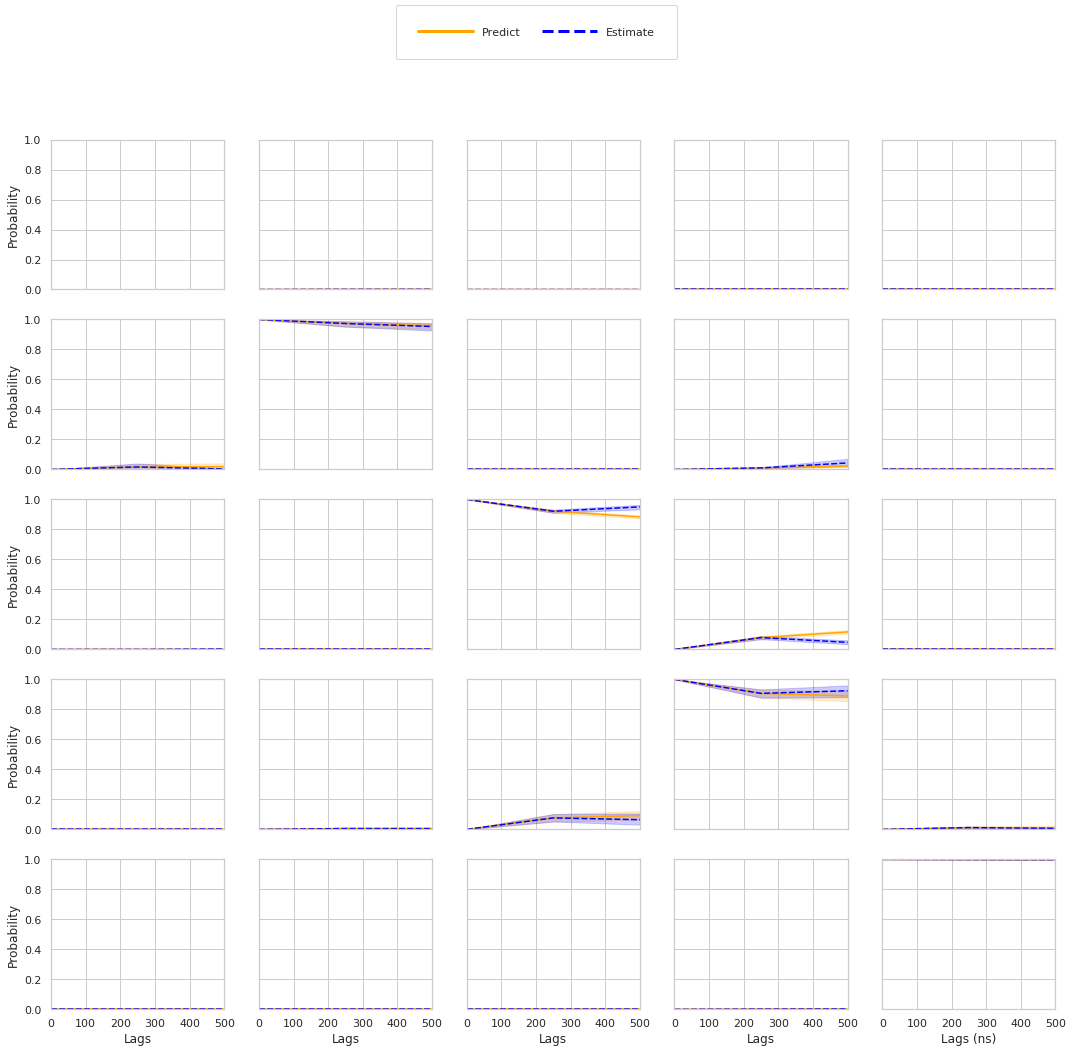

In [48]:
sns.set_context("notebook")
sns.set_style("whitegrid")
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(18, 16))
for i in range(5):
    for j in range(5):
        df = pd.DataFrame(data_frames[str(i) + "-" + str(j)])
        sns.lineplot(x='Lags', y="Probability", data=df, hue="Order", style="Order", legend=False, ax=axs[i,j], palette=["orange", "blue"])

plt.xlim([0,500])
plt.ylim([0,1])
#plt.yscale("log")
plt.xlabel("Lags (ns)")
#plt.ylabel("Probability")
#plt.legend()
from matplotlib.lines import Line2D

colors = ['orange', 'blue']
lines = [Line2D([0], [0], color="orange", linewidth=3, linestyle='-'), Line2D([0], [0], color="blue", linewidth=3, linestyle='--')]
labels = ['Predict', 'Estimate']
fig.legend(lines, labels, loc='upper center', borderpad=2, ncol=2, handlelength=5)
plt.savefig('/home/jabella/Downloads/' + mode + '/ckplot.png', dpi=500)

In [49]:
# bootstrap
dG_boot = []
for b in range(100):
    us = pyemma.load("bootstrap/us_obj_" + str(250*25) + "_" + str(b),"us_obj")
    MSM = pyemma.load("bootstrap/msm_obj_" + str(250*25) + "_" + str(b),"msm_obj")

    active_set = us.active_set
    mu = us.stationary_distribution
    nstates = us.nstates

    # state definitions
    unbound_states = []
    associated_states = []
    native_states = []
    cterm_bound_states = []
    nterm_bound_states = []
    anchor_cutoff = 0.2
    state_to_macrostate = []
    #print(nstates, len(active_set))
    for MSM_state in range(nstates):
        cluster_index = active_set[MSM_state]
        nterm_rmsd, cterm_rmsd = cluster_feats_rmsd[cluster_index]
        #if nterm_rmsd < anchor_cutoff and cterm_rmsd < anchor_cutoff: native_states.append(MSM_state)
        if cluster_feats_r[cluster_index] < 0.2: 
            native_states.append(MSM_state)
            state_to_macrostate.append(0)
        elif nterm_rmsd >= anchor_cutoff and cterm_rmsd < anchor_cutoff: 
            cterm_bound_states.append(MSM_state)
            state_to_macrostate.append(2)
        elif nterm_rmsd < anchor_cutoff and cterm_rmsd >= anchor_cutoff: 
            nterm_bound_states.append(MSM_state)
            state_to_macrostate.append(1)
        #elif cluster_index == len(index_clusters) - 1: unbound_states.append(MSM_state)
        elif cluster_feats[cluster_index] > 0.5: 
            unbound_states.append(MSM_state)
            state_to_macrostate.append(4)
        else: 
            associated_states.append(MSM_state)
            state_to_macrostate.append(3)
    #print(unbound_states, native_states, cterm_bound_states, nterm_bound_states)
    #print(len(unbound_states))
    if len(unbound_states) == 0: continue
    macro_p = [np.sum(mu[native_states]), np.sum(mu[nterm_bound_states]), np.sum(mu[cterm_bound_states]), np.sum(mu[associated_states]), np.sum(mu[unbound_states])]
    #print(np.sum(macro_p))

    #unbound_states = [100]
    #unbound_states = [MSM.nstates-1]
    #bound_states = [j for j in range(MSM.nstates) if j not in unbound_states]
    bound_states = associated_states + native_states + cterm_bound_states + nterm_bound_states
    #print(MSM.mfpt(unbound_states, bound_states))
    #print(MSM.mfpt(bound_states, unbound_states))
    RT = 2.479
    dG = RT*np.log(np.sum(mu[unbound_states]) / np.sum(mu[bound_states]))
    #print("p(Bound):", np.sum(mu[bound_states]))
    #print("p(Unbound):", np.sum(mu[unbound_states]))
    #print("RT*ln(p_unbound / p_bound):", dG)

    dG_boot.append(dG)

print(len(dG_boot))
print(np.mean(dG_boot), scipy.stats.sem(dG_boot))
#print(dG_boot)

100
-3.0779046523351017 1.004788627929783


In [50]:
data_frame = {'Lags':[], 'Timescale':[], 'Order':[]}
f = np.load("msm_timescales.npz", allow_pickle=True)
lags = f["lags"]
for lag in lags:
    for b in range(100):
        us = pyemma.load("bootstrap/us_obj_" + str(lag) + "_" + str(b),"us_obj")
        MSM = pyemma.load("bootstrap/msm_obj_" + str(lag) + "_" + str(b),"msm_obj")
        timescales = MSM.timescales()
        for t in range(10):
            data_frame["Lags"].append(lag * steps_to_nanoseconds)
            data_frame["Timescale"].append(timescales[t] * steps_to_nanoseconds)
            data_frame["Order"].append(t)



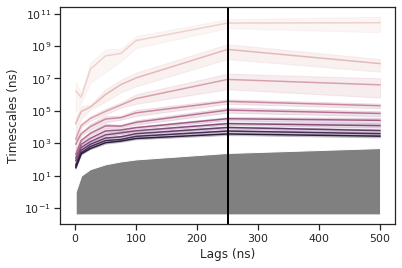

In [51]:
sns.set_context("notebook")
sns.set_style("ticks")
#plt.figure(figsize=(20,10))
df = pd.DataFrame(data_frame)
ax = sns.lineplot(x='Lags', y="Timescale", data=df, hue="Order", legend=False)
#plt.xlim([0.97,0.98])
plt.yscale("log")
plt.xlabel("Lags (ns)")
plt.ylabel("Timescales (ns)")

plt.fill_between(lags * steps_to_nanoseconds, 1*steps_to_nanoseconds, lags * steps_to_nanoseconds, facecolor='Gray')

plt.axvline(250, linewidth=2, color='black')

plt.savefig('/home/jabella/Downloads/' + mode + '/msm_ts_over_lags.png', dpi=500)

## Visualize Conformations

In [141]:
# visualize trajectory
import nglview
from matplotlib.colors import to_hex
import glob

widget = nglview.NGLWidget()
widget.clear_representations()

trajindex = "0016"
#trajindex = "extra/9"
topfile = glob.glob(trajindex + "/aln*.pdb")[0]

#s = md.load("0000/output_every1ns_fix.dcd", top=topfile)
#widget.add_trajectory(s)

s = md.load(topfile)
traj = md.load(trajindex + "/output_every1ns_fix.dcd", top=topfile)
widget.add_trajectory(traj)

#topfile = glob.glob("0001/aln*.pdb")[0]
#s = md.load(topfile)
#widget.add_trajectory(s)

#print(s, topfile)

widget

NGLWidget(max_frame=25000)

In [19]:
import nglview
from matplotlib.colors import to_hex
import glob

widget = nglview.NGLWidget()
widget.clear_representations()

#trajindex = "0579"
#trajindex = "extra/9"
topfile = glob.glob("/home/jabella/native_state_us/0000/aln*.pdb")[0]
s = md.load("/home/jabella/native_state_us/traj_concat.dcd", top=topfile)
#s = md.load("/home/jabella/native_state_us/confs4.dcd", top=topfile)
widget.add_trajectory(s)

#widget.add_trajectory(md.load("/home/jabella/Downloads/restart.pdb"))

widget

NGLWidget(max_frame=2213)